# UKB Prescriptions drug filtering 

Using gp_scripts database and comparing with omap_era database

Drugs for this study: loperamide, methadone,fentanyl, morphine, sufentanil.

In [1]:
!pip install upsetplot
!pip install scikit-learn

In [2]:
import pyspark
import dxpy
import dxdata
import pyspark.sql.functions as F

import pandas as pd
import re
from upsetplot import UpSet
import matplotlib.pyplot as plt
import matplotlib.cm as cm

import numpy as np
from sklearn.preprocessing import StandardScaler

In [3]:
sc = pyspark.SparkContext()
spark = pyspark.sql.SparkSession(sc)

dispensed_database_name = dxpy.find_one_data_object(
    classname="database", name="app*", folder="/", name_mode="glob", describe=True
)["describe"]["name"]
dispensed_dataset_id = dxpy.find_one_data_object(
    typename="Dataset", name="app*.dataset", folder="/", name_mode="glob"
)["id"]

spark.sql("USE " + dispensed_database_name)

dataset = dxdata.load_dataset(id=dispensed_dataset_id)

In [4]:
# Init pyspark and load dataframe
# Load the 'gp_scripts'  table
scripts = dataset["gp_scripts"]

# Extract all field names from the table
field_names = [f.name for f in scripts.fields]

# Retrieve the fields
df_scripts = scripts.retrieve_fields(names=field_names, engine=dxdata.connect())

print(f"Total rows: {df_scripts.count()}")
print(f"Distinct EID: {df_scripts.select('eid').distinct().count()}")
df_scripts.drop("eid").show(truncate=False)

Total rows: 56205016
Distinct EID: 222014
+-------------+----------+-------+---------------+---------+-------------------------------------------------------------+---------------+
|data_provider|issue_date|read_2 |bnf_code       |dmd_code |drug_name                                                    |quantity       |
+-------------+----------+-------+---------------+---------+-------------------------------------------------------------+---------------+
|3            |2001-11-08|null   |04.07.02.00.00 |null     |Kapake 30mg/500mg tablets (Galen Ltd)                        |100 tablet(s)  |
|4            |2011-12-28|blf2.  |null           |null     |null                                                         |null           |
|3            |2015-11-24|null   |03.01.01.03.00 |null     |Ventolin 100micrograms/dose Evohaler (GlaxoSmithKline UK Ltd)|400 dose       |
|2            |2006-12-29|null   |0501030I0AAABAB|null     |DOXYCYCLINE CAPSULES 100MG                                   |8.

Now filter the dataset for the drugs of interest

In [5]:
# List of drugs to search for
drugs_to_search = ["loperamide", "methadone", "fentanyl", "morphine", "sufentanil"]

# Initialize a dictionary to store the filtered DataFrames
filtered_dfs = {}
# Loop through each drug to filter and check if it appears in the dataset
for drug in drugs_to_search:
    # Filter the rows that contain the drug name (case insensitive search)
    # Use regular expression to match only the exact word 'morphine' and avoid partial matches
    filtered_df = df_scripts.filter(
        F.lower(df_scripts["drug_name"]).rlike(r"\b" + drug.lower() + r"\b")
    )

    # Check if the filtered DataFrame is empty
    if filtered_df.count() > 0:
        print(f"Rows containing '{drug}':")
        print(filtered_df.count())
        # Format the date columns (if necessary)
        filtered_df = filtered_df.withColumn(
            "issue_date", F.to_date(F.col("issue_date"), "dd/MM/yyyy")
        )
        filtered_df.drop("eid").show(truncate=False)
        # Create a dynamic variable name for each drug's filtered DataFrame
        filtered_dfs[drug] = filtered_df
        print(f"Filtered df for '{drug}' created successfully.")
    else:
        print(f"The drug '{drug}' does not appear in this dataset.")

Rows containing 'loperamide':
92237
+-------------+----------+-------+--------------+----------------+-------------------------------------------+------------------------+
|data_provider|issue_date|read_2 |bnf_code      |dmd_code        |drug_name                                  |quantity                |
+-------------+----------+-------+--------------+----------------+-------------------------------------------+------------------------+
|1            |2008-11-28|a83z.00|null          |3486711000001101|Loperamide 1mg/5ml oral solution sugar free|200.000                 |
|3            |2001-11-22|null   |01.04.02.00.00|null            |Loperamide 2mg capsules                    |60 capsule(s) - 2 mg    |
|3            |2010-01-11|null   |01.04.02.00.00|null            |Loperamide 2mg capsules                    |60 capsules - 2 mg      |
|3            |2013-04-05|null   |01.04.02.00.00|null            |Loperamide 2mg capsules                    |60 capsule              |
|3          

In [6]:
# For each item in the dictionary, convert the PySpark DataFrame to Pandas DataFrame
for drug, filtered_df in filtered_dfs.items():
    # Convert the PySpark DataFrame to a Pandas DataFrame
    pandas_df = filtered_df.toPandas()
    globals()[f"pandas_df_{drug}"] = pandas_df

Now let's continue analysis our prescription data, we want to parse the data frames to standarize them. 

Start with morphine

In [7]:
# Access columns 'drug_name' and 'quantity'
display(pandas_df_morphine[["drug_name", "quantity"]])
print(pandas_df_morphine["drug_name"].unique())
print(pandas_df_morphine["quantity"].unique())

,drug_name,quantity
0,Morphine 60mg modified-release tablets,60 tablet(s)
1,Morphine sulfate 10mg/5ml oral solution,600 millilitres
2,Morphine sulfate 10mg/5ml oral solution,100 ml - 10 mg/5 ml
3,morphine sulfate 12 hour modified release caps...,60 capsule(s)
4,Morphine sulfate 10mg/5ml oral solution,100 ml - 10 mg/5 ml
...,...,...
35391,Morphine sulfate 10mg/5ml oral solution,2 packs of 300 mls
35392,Morphine sulfate 10mg/5ml oral solution,300 ml
35393,Morphine Sulfate M/R tablets 30 mg,30.000
35394,Morphine Sulfate M/R tablets 10 mg,60.000


['Morphine 60mg modified-release tablets'
 'Morphine sulfate 10mg/5ml oral solution'
 'morphine sulfate 12 hour modified release capsules 20mg'
 'Morphine sulfate 10mg/1ml solution for injection ampoules'
 'Morphine sulfate 10mg/1ml solution for injection ampoules (Wockhardt UK Ltd)'
 'morphine sulfate 24 hour modified release capsules 150mg'
 'Morphine 100mg modified-release tablets'
 'Morphine Sulfate  Oral solution  10 mg/5 ml'
 'Morphine sulfate 10mg/5ml oral solution unit dose vials sugar free'
 'Morphine sulphate 10mg/5ml oral solution'
 'Morphine 10mg modified-release tablets'
 'morphine sulfate injection 10mg/1ml' 'Morphine 10mg tablets'
 'Morphine Sulphate Mr TABS 10MG' 'Morphine 5mg modified-release tablets'
 'Morphine 15mg modified-release tablets' 'MORPHINE SULPHATE tabs 10mg'
 'MORPHINE SULPHATE mr tab 5mg' 'Morphine 30mg modified-release tablets'
 'Morphine Sulfate  Tablets  10 mg' 'MORPHINE SULPHATE mr tab 10mg'
 'Morphine 10mg modified-release capsules'
 'Morphine sulfa

In [8]:
def normalize(name):
    if name is None:
        return ""  # Return empty string for None values or you can return the original value if desired
        # If the name is already a number (int or float), return it as an integer if it's a whole number
    # Check if the string is numeric (e.g., "30", "30.000", "100")
    if re.match(r"^\d+(\.\d+)?$", name):  # Match numbers and floats as strings
        # Convert to float and then return a str back
        num = float(name)
        return str(num)
    name = name.lower()  # Lowercase
    name = re.sub(r"\s+", " ", name)  # Normalize whitespace
    name = re.sub(r"[^a-z0-9\s/]", "", name)  # Remove special characters
    return name


# Function to parse quantity into structured components
def parse_quantity(quantity):
    if not isinstance(quantity, str):
        return {"quantity": None, "unit": None, "details": None}

    # Extract numeric quantity
    quantity_match = re.search(r"(\d+(\.\d+)?)", quantity)
    numeric_quantity = float(quantity_match.group(1)) if quantity_match else None
    # If the numeric quantity is an integer (i.e., no decimal part), return it as an integer

    # Extract unit (e.g., tablet(s), millilitres, etc.)
    unit_match = re.search(
        r"(tablet|cap|ampoule|millilitre|ml|pack|vial|sachet|dose vial|suppository|prefilled syringe)",
        quantity,
        re.IGNORECASE,
    )
    unit = unit_match.group(0).lower() if unit_match else None

    # Extract details, which includes everything after the unit
    details_start_index = quantity.lower().find(unit) + len(unit) if unit else None
    details = quantity[details_start_index:].strip() if details_start_index else None

    return {"quantity": numeric_quantity, "unit": unit, "details": details}


# Function to extract concentrations (mg, mg/ml, etc.)
def extract_concentration_from_text(text):
    # Check if the text is a valid non-empty string
    if isinstance(text, str) and text.strip():
        # Regular expression pattern to match concentrations with valid units
        pattern = r"(\d+\.?\d*\s?(mg/ml|mg/\d+ml|mg/\d+ ml|mg|g|ml|mls|mg/sachet|X \d+ml| X \d+ml|ampoule|tablet|vial|cap|\d+prefilled syringe))"

        # Find all matches in the text
        matches = re.findall(pattern, text, re.IGNORECASE)

        # If matches are found, return the first match (or None if no matches)
        if matches:
            return matches[0][0]  # Return the first match
        else:
            return None  # No match found, return None
    else:
        return None  # If input is empty or invalid, return None


def extract_concentration_from_text_parsed_details(text):
    # Check if the text is a valid non-empty string
    if isinstance(text, str) and text.strip():
        # Regular expression pattern to match concentrations with valid units
        pattern = r"(\d+\.?\d*\s?(mg/ml|mg/\d+ml|mg/\d+ ml|mg|g|ml|mls|mg/sachet|X \d+ml| X \d+ml|ampoule|sachet|tablet|vial|cap|prefilled syringe|\d+))"
        # Find all matches in the text
        matches = re.findall(pattern, text, re.IGNORECASE)

        # If matches are found, return the first match (or None if no matches)
        if matches:
            return matches[0][0]  # Return the first match
        else:
            return None  # No match found, return None
    else:
        return None  # If input is empty or invalid, return None


# Apply normalization and parsing
pandas_df_morphine["normalized_drug_name"] = pandas_df_morphine["drug_name"].apply(
    normalize
)
pandas_df_morphine["normalized_quantity"] = pandas_df_morphine["quantity"].apply(
    normalize
)
pandas_df_morphine["parsed_concentration_drug_name"] = pandas_df_morphine[
    "normalized_drug_name"
].apply(extract_concentration_from_text)
pandas_df_morphine[["parsed_quantity", "parsed_unit", "parsed_details"]] = (
    pandas_df_morphine[
        "normalized_quantity"
    ].apply(lambda x: pd.Series(parse_quantity(x)))
)
pandas_df_morphine["parsed_details"] = pandas_df_morphine["parsed_details"].apply(
    extract_concentration_from_text_parsed_details
)

# Output the transformed DataFrame
display(pandas_df_morphine.drop("eid", axis=1))

,data_provider,issue_date,read_2,bnf_code,dmd_code,drug_name,quantity,normalized_drug_name,normalized_quantity,parsed_concentration_drug_name,parsed_quantity,parsed_unit,parsed_details
0,3,2006-02-20,None,04.07.02.00.00,None,Morphine 60mg modified-release tablets,60 tablet(s),morphine 60mg modifiedrelease tablets,60 tablets,60mg,60.0,tablet,None
1,3,2013-07-15,None,04.07.02.00.00,None,Morphine sulfate 10mg/5ml oral solution,600 millilitres,morphine sulfate 10mg/5ml oral solution,600 millilitres,10mg/5ml,600.0,millilitre,None
2,3,2011-01-10,None,04.07.02.00.00,None,Morphine sulfate 10mg/5ml oral solution,100 ml - 10 mg/5 ml,morphine sulfate 10mg/5ml oral solution,100 ml 10 mg/5 ml,10mg/5ml,100.0,ml,10 mg/5 ml
3,3,2005-12-16,None,04.07.02.00.00,None,morphine sulfate 12 hour modified release caps...,60 capsule(s),morphine sulfate 12 hour modified release caps...,60 capsules,20mg,60.0,cap,None
4,3,2013-02-20,None,04.07.02.00.00,None,Morphine sulfate 10mg/5ml oral solution,100 ml - 10 mg/5 ml,morphine sulfate 10mg/5ml oral solution,100 ml 10 mg/5 ml,10mg/5ml,100.0,ml,10 mg/5 ml
...,...,...,...,...,...,...,...,...,...,...,...,...,...
35391,3,2015-11-13,None,04.07.02.00.00,None,Morphine sulfate 10mg/5ml oral solution,2 packs of 300 mls,morphine sulfate 10mg/5ml oral solution,2 packs of 300 mls,10mg/5ml,2.0,pack,300 ml
35392,3,2016-03-16,None,04.07.02.00.00,None,Morphine sulfate 10mg/5ml oral solution,300 ml,morphine sulfate 10mg/5ml oral solution,300 ml,10mg/5ml,300.0,ml,None
35393,2,2017-01-26,None,040702,None,Morphine Sulfate M/R tablets 30 mg,30.000,morphine sulfate m/r tablets 30 mg,30.0,30 mg,30.0,NaN,None
35394,2,2015-11-03,None,040702,None,Morphine Sulfate M/R tablets 10 mg,60.000,morphine sulfate m/r tablets 10 mg,60.0,10 mg,60.0,NaN,None


In [9]:
print(pandas_df_morphine["parsed_concentration_drug_name"].unique())
print(pandas_df_morphine["parsed_unit"].unique())
print(pandas_df_morphine["parsed_details"].unique())

['60mg' '10mg/5ml' '20mg' '10mg/1ml' '150mg' '100mg' '10 mg/5 ml' '10mg'
 '5mg' '15mg' '30mg' '10 mg' '20mg/ml' None '10mg/ml' '15 mg' '30mg/1ml'
 '200mg' '50mg' '20 mg' '30 mg' '20mg/1ml' '10 mg/ml' '15mg/1ml'
 '60mg/2ml' '60 mg' '120mg' '1mg/1ml' '90mg' '5ml' '30mg/5ml' '1mg/5ml'
 '5 mg' '84mg/ml']
['tablet' 'millilitre' 'ml' 'cap' 'ampoule' 'pack' nan 'vial' None
 'sachet' 'suppository' 'dose vial' 'prefilled syringe']
[None '10 mg/5 ml' '300 ml' '100 ml' '28 cap' '60 tablet' '500 ml' '10 mg'
 '30 ml' '10 mg/ml' '5 mg' '30 mg' '60 mg' '100 ampoule' '5 vial' '20 mg'
 '20 x 5ml' '56 tablet' '10 ampoule' '60 cap' '200 ml' '30 mg/ml' '15 mg'
 '30 sachet' '120 ml' '90 mg' '120 mg' '20 mg/ml' '100 mg'
 '1 prefilled syringe' '5ml' '2 g' '5 ampoule' '12' '3000 ml' '50 mg']


In [10]:
# Filter the dataframe where parsed_unit is 'pack'
filter = pandas_df_morphine[pandas_df_morphine["parsed_unit"] == "pack"]

# Print the unique values of 'parsed_details' for this filtered dataframe
print(filter["parsed_details"].unique())

['300 ml' '100 ml' '28 cap' '60 tablet' '500 ml' '30 ml' '100 ampoule'
 '5 vial' '56 tablet' '10 ampoule' '60 cap' '200 ml' '30 sachet' '120 ml'
 '20 x 5ml' '1 prefilled syringe' '2 g' '5 ampoule' '12' '3000 ml']


In [11]:
def parse_to_number(value):
    """
    Parses a concentration string and returns a numeric representation.
    Handles cases like "30mg/5ml", "20mg/ml", and single numbers like "10 mg".
    """
    if value is None:  # Handle None values
        return None

    # Find all numeric parts
    numbers = re.findall(r"\d+(?:\.\d+)?", value)

    # Handle concentrations in the form "20mg/ml" or "30mg/5ml"
    if "/" in value:
        if len(numbers) >= 1:  # Ensure at least one number exists
            num = float(numbers[0])  # Numerator is the first number
            den = 1.0  # Default denominator is 1.0 (for cases like /ml)
            if len(numbers) > 1:
                den = float(numbers[1])  # Use the second number if present
            return num / den

    # Handle single numbers like "10 mg" or "20mg"
    elif numbers:
        return float(numbers[0])  # Use the first number
    return None  # Return None for non-parsable cases


pandas_df_morphine["parsed_concentration"] = pandas_df_morphine[
    "parsed_concentration_drug_name"
].apply(parse_to_number)

In [12]:
def calculate_quantity_mg(row):
    concentration = row["parsed_concentration"]
    unit = row["parsed_unit"]
    details = row["parsed_details"]
    quantity = row["parsed_quantity"]

    # Handle unit-based logic
    if pd.isna(unit):
        return quantity * concentration
    elif unit in [
        "tablet",
        "cap",
        None,
        "sachet",
        "suppository",
        "ml",
        "millilitre",
        "NaN",
        "ampoule",
        "prefilled syringe",
    ]:
        return quantity * concentration
    elif unit in ["dose vial", "vial"]:
        return quantity * 5 * concentration
    elif unit == "pack":
        if details:
            if (
                "ml" in details
                or "cap" in details
                or "tablet" in details
                or "sachet" in details
            ):
                detail_quantity = float(re.findall(r"\d+", details)[0])
                return quantity * detail_quantity * concentration
            elif "vial" in details:
                vial_quantity = float(re.findall(r"\d+", details)[0])
                return quantity * vial_quantity * 5 * concentration
            elif "ampoule" in details or "prefilled syringe" in details:
                ampoule_quantity = float(re.findall(r"\d+", details)[0])
                return quantity * ampoule_quantity * concentration
            elif "2 g" in details:
                return 200 * quantity
            elif "x" in details:
                match = re.search(r"(\d+)\s*[xX]\s*(\d+)", details)
                if match:
                    packs, per_pack = map(float, match.groups())
                    return quantity * packs * per_pack * concentration
            else:
                return quantity * concentration
        else:
            return quantity * concentration
    return None


# Apply the function to the DataFrame
pandas_df_morphine["quantity_mg"] = pandas_df_morphine.apply(
    calculate_quantity_mg, axis=1
)
display(pandas_df_morphine.drop("eid", axis=1))

,data_provider,issue_date,read_2,bnf_code,dmd_code,drug_name,quantity,normalized_drug_name,normalized_quantity,parsed_concentration_drug_name,parsed_quantity,parsed_unit,parsed_details,parsed_concentration,quantity_mg
0,3,2006-02-20,None,04.07.02.00.00,None,Morphine 60mg modified-release tablets,60 tablet(s),morphine 60mg modifiedrelease tablets,60 tablets,60mg,60.0,tablet,None,60.0,3600.0
1,3,2013-07-15,None,04.07.02.00.00,None,Morphine sulfate 10mg/5ml oral solution,600 millilitres,morphine sulfate 10mg/5ml oral solution,600 millilitres,10mg/5ml,600.0,millilitre,None,2.0,1200.0
2,3,2011-01-10,None,04.07.02.00.00,None,Morphine sulfate 10mg/5ml oral solution,100 ml - 10 mg/5 ml,morphine sulfate 10mg/5ml oral solution,100 ml 10 mg/5 ml,10mg/5ml,100.0,ml,10 mg/5 ml,2.0,200.0
3,3,2005-12-16,None,04.07.02.00.00,None,morphine sulfate 12 hour modified release caps...,60 capsule(s),morphine sulfate 12 hour modified release caps...,60 capsules,20mg,60.0,cap,None,20.0,1200.0
4,3,2013-02-20,None,04.07.02.00.00,None,Morphine sulfate 10mg/5ml oral solution,100 ml - 10 mg/5 ml,morphine sulfate 10mg/5ml oral solution,100 ml 10 mg/5 ml,10mg/5ml,100.0,ml,10 mg/5 ml,2.0,200.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
35391,3,2015-11-13,None,04.07.02.00.00,None,Morphine sulfate 10mg/5ml oral solution,2 packs of 300 mls,morphine sulfate 10mg/5ml oral solution,2 packs of 300 mls,10mg/5ml,2.0,pack,300 ml,2.0,1200.0
35392,3,2016-03-16,None,04.07.02.00.00,None,Morphine sulfate 10mg/5ml oral solution,300 ml,morphine sulfate 10mg/5ml oral solution,300 ml,10mg/5ml,300.0,ml,None,2.0,600.0
35393,2,2017-01-26,None,040702,None,Morphine Sulfate M/R tablets 30 mg,30.000,morphine sulfate m/r tablets 30 mg,30.0,30 mg,30.0,NaN,None,30.0,900.0
35394,2,2015-11-03,None,040702,None,Morphine Sulfate M/R tablets 10 mg,60.000,morphine sulfate m/r tablets 10 mg,60.0,10 mg,60.0,NaN,None,10.0,600.0


In [13]:
# Now let see if there is any NaN values in the quantity_mg column
print(pandas_df_morphine["quantity_mg"].isna().sum())
nan_values = pandas_df_morphine[pandas_df_morphine["quantity_mg"].isna()]
display(nan_values.drop("eid", axis=1))

253


,data_provider,issue_date,read_2,bnf_code,dmd_code,drug_name,quantity,normalized_drug_name,normalized_quantity,parsed_concentration_drug_name,parsed_quantity,parsed_unit,parsed_details,parsed_concentration,quantity_mg
483,3,2006-09-18,None,01.04.02.00.00,None,Kaolin and Morphine mixture,200 ml - bp,kaolin and morphine mixture,200 ml bp,None,200.0,ml,None,NaN,NaN
498,3,2004-03-08,None,01.04.02.00.00,None,Kaolin and Morphine mixture,2 litre(s),kaolin and morphine mixture,2 litres,None,2.0,NaN,None,NaN,NaN
1047,3,2004-04-02,None,01.04.02.00.00,None,Kaolin and Morphine mixture,200 mls,kaolin and morphine mixture,200 mls,None,200.0,ml,None,NaN,NaN
1479,3,1992-03-26,None,01.04.02.00.00,None,Kaolin and Morphine mixture,1.00 OP,kaolin and morphine mixture,100 op,None,100.0,NaN,None,NaN,NaN
1832,1,2017-03-24,a842.00,None,14610811000001109,Kaolin and Morphine mixture,200.000,kaolin and morphine mixture,200.0,None,200.0,NaN,None,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
35030,3,2002-04-03,None,01.04.02.00.00,None,Kaolin and Morphine mixture,100 ml,kaolin and morphine mixture,100 ml,None,100.0,ml,None,NaN,NaN
35154,3,2005-08-08,None,01.04.02.00.00,None,Kaolin and Morphine mixture,200 mls,kaolin and morphine mixture,200 mls,None,200.0,ml,None,NaN,NaN
35217,3,2013-08-08,None,01.04.02.00.00,None,Kaolin and Morphine mixture,200 millilitres,kaolin and morphine mixture,200 millilitres,None,200.0,millilitre,None,NaN,NaN
35262,3,2015-10-22,None,04.07.02.00.00,None,morphine sulfate oral liquid,100 millilitres,morphine sulfate oral liquid,100 millilitres,None,100.0,millilitre,None,NaN,NaN


Kaolin and morphine is an OTC medicine used for symptomatic relief of diarrhoea so I will not include it in this table, it could maybe be interested to study if there is drug switch to loperamide that is also used for this. However there is not a lot of eids with this drug prescription so maybe it is not stadistically significant.

In [14]:
# Filter out rows where 'drug_name' contains the word "kaolin" (case-insensitive)
pandas_df_morphine = pandas_df_morphine[
    ~pandas_df_morphine["drug_name"].str.contains("kaolin", case=False, na=False)
]
print(pandas_df_morphine["quantity_mg"].isna().sum())
nan_values = pandas_df_morphine[pandas_df_morphine["quantity_mg"].isna()]
display(nan_values.drop("eid", axis=1))

12


,data_provider,issue_date,read_2,bnf_code,dmd_code,drug_name,quantity,normalized_drug_name,normalized_quantity,parsed_concentration_drug_name,parsed_quantity,parsed_unit,parsed_details,parsed_concentration,quantity_mg
1873,3,2016-01-06,None,04.07.02.00.00,None,Morphine sulfate 10mg/5ml oral solution,None,morphine sulfate 10mg/5ml oral solution,,10mg/5ml,NaN,None,None,2.0,NaN
9337,3,1998-05-29,None,04.07.02.00.00,None,Morphine 10mg tablets,See Dosage For Quantity,morphine 10mg tablets,see dosage for quantity,10mg,NaN,None,None,10.0,NaN
9350,3,1998-06-02,None,04.07.02.00.00,None,Morphine 10mg tablets,See Dosage For Quantity,morphine 10mg tablets,see dosage for quantity,10mg,NaN,None,None,10.0,NaN
9352,3,1998-02-27,None,04.07.02.00.00,None,Morphine 10mg tablets,See Dosage For Quantity,morphine 10mg tablets,see dosage for quantity,10mg,NaN,None,None,10.0,NaN
14424,3,2012-05-05,None,04.07.02.00.00,None,Morphine sulfate 10mg/5ml oral solution,None,morphine sulfate 10mg/5ml oral solution,,10mg/5ml,NaN,None,None,2.0,NaN
15293,3,1998-04-28,None,04.07.02.00.00,None,Morphine 10mg tablets,See Dosage For Quantity,morphine 10mg tablets,see dosage for quantity,10mg,NaN,None,None,10.0,NaN
16127,3,2005-10-31,None,04.07.02.00.00,None,Morphine sulfate 10mg/5ml oral solution,See Dosage For Quantity,morphine sulfate 10mg/5ml oral solution,see dosage for quantity,10mg/5ml,NaN,None,None,2.0,NaN
19783,3,2001-04-06,None,04.07.02.00.00,None,Morphine sulfate 10mg/5ml oral solution,See Dosage For Quantity,morphine sulfate 10mg/5ml oral solution,see dosage for quantity,10mg/5ml,NaN,None,None,2.0,NaN
20331,3,2014-08-11,None,04.07.02.00.00,None,Morphine sulfate 10mg/1ml solution for injecti...,None,morphine sulfate 10mg/1ml solution for injecti...,,10mg/1ml,NaN,None,None,10.0,NaN
25594,3,2010-09-08,None,04.07.02.00.00,None,Morphine sulfate 10mg/5ml oral solution,None,morphine sulfate 10mg/5ml oral solution,,10mg/5ml,NaN,None,None,2.0,NaN


We just have 12 rows that does not give information about mg of morphine so we leave it like this


In [15]:
# Select specific columns and add 'drug_name' column
pandas_df_morphine = pandas_df_morphine[
    ["eid", "issue_date", "quantity", "quantity_mg"]
].copy()
pandas_df_morphine["drug_name"] = "morphine"

display(pandas_df_morphine.drop("eid", axis=1))
pandas_df_morphine.to_csv("prescription_df_morphine.csv", index=False)

,issue_date,quantity,quantity_mg,drug_name
0,2006-02-20,60 tablet(s),3600.0,morphine
1,2013-07-15,600 millilitres,1200.0,morphine
2,2011-01-10,100 ml - 10 mg/5 ml,200.0,morphine
3,2005-12-16,60 capsule(s),1200.0,morphine
4,2013-02-20,100 ml - 10 mg/5 ml,200.0,morphine
...,...,...,...,...
35391,2015-11-13,2 packs of 300 mls,1200.0,morphine
35392,2016-03-16,300 ml,600.0,morphine
35393,2017-01-26,30.000,900.0,morphine
35394,2015-11-03,60.000,600.0,morphine


Now we continue standarizing loperamide

In [16]:
# Access columns 'drug_name' and 'quantity'
display(pandas_df_loperamide[["drug_name", "quantity"]])
print(pandas_df_loperamide["drug_name"].unique())
print(pandas_df_loperamide["quantity"].unique())

,drug_name,quantity
0,Loperamide 1mg/5ml oral solution sugar free,200.000
1,Loperamide 2mg capsules,60 capsule(s) - 2 mg
2,Loperamide 2mg capsules,60 capsules - 2 mg
3,Loperamide 2mg capsules,60 capsule
4,Loperamide 2mg capsules,20 cap
...,...,...
92232,Loperamide 2mg tablets,120.000
92233,Loperamide 2mg capsules,30 capsules
92234,Loperamide 2mg capsules,30 capsule(s)
92235,Loperamide 2mg capsules,60 - capsule(s)


['Loperamide 1mg/5ml oral solution sugar free' 'Loperamide 2mg capsules'
 'LOPERAMIDE caps 2mg' 'LOPERAMIDE HYDROCHLO CAP 2'
 'Loperamide 2mg capsules (Actavis UK Ltd)' 'Loperamide 2mg tablets'
 'LOPERAMIDE HYDROCHLORIDE CAP 2mg'
 'Loperamide Hydrochloride  Capsules  2 mg'
 'Loperamide Hydrochloride CAPS 2MG' 'LOPERAMIDE CAPS 2MG'
 'LOPERAMIDE sf oral soln 1mg/5ml'
 'Loperamide Hydrochloride  Tablets  2 mg'
 'LOPERAMIDE HYDROCHLORIDE CAPSULES 2MG'
 'loperamide oral lyophilisate tablet 2mg' 'LOPERAMIDE 2mg'
 'LOPERAMIDE tabs 2mg' 'Loperamide Hydrochloride Capsules 2 mg'
 'LOPERAMIDE caps 2 MG' 'Loperamide Hydrochloride TABS 2MG'
 'Loperamide Hydrochloride Tablets 2 mg'
 'LOPERAMIDE HYDROCHLORIDE 2mg capsules'
 'Loperamide Hydrochloride Sf SYRUP 1MG/5ML'
 'Loperamide hydrochloride 2 mg capsules'
 'Loperamide 2mg oral lyophilisates sugar free'
 'Loperamide 2mg capsules (Teva UK Ltd)'
 'LOPERAMIDE HYDROCHLORIDE TABLETS 2MG' 'LOPERAMIDE capsules 2mg'
 'Loperamide Hydrochloride CAPSULES 2MG'

In [17]:
# Apply normalization and parsing
pandas_df_loperamide["normalized_drug_name"] = pandas_df_loperamide["drug_name"].apply(
    normalize
)
pandas_df_loperamide["normalized_quantity"] = pandas_df_loperamide["quantity"].apply(
    normalize
)
pandas_df_loperamide["parsed_concentration_drug_name"] = pandas_df_loperamide[
    "normalized_drug_name"
].apply(extract_concentration_from_text)
pandas_df_loperamide[["parsed_quantity", "parsed_unit", "parsed_details"]] = (
    pandas_df_loperamide[
        "normalized_quantity"
    ].apply(lambda x: pd.Series(parse_quantity(x)))
)
pandas_df_loperamide["parsed_details"] = pandas_df_loperamide["parsed_details"].apply(
    extract_concentration_from_text_parsed_details
)

# Output the transformed DataFrame
display(pandas_df_loperamide.drop("eid", axis=1))

,data_provider,issue_date,read_2,bnf_code,dmd_code,drug_name,quantity,normalized_drug_name,normalized_quantity,parsed_concentration_drug_name,parsed_quantity,parsed_unit,parsed_details
0,1,2008-11-28,a83z.00,None,3486711000001101,Loperamide 1mg/5ml oral solution sugar free,200.000,loperamide 1mg/5ml oral solution sugar free,200.0,1mg/5ml,200.0,NaN,None
1,3,2001-11-22,None,01.04.02.00.00,None,Loperamide 2mg capsules,60 capsule(s) - 2 mg,loperamide 2mg capsules,60 capsules 2 mg,2mg,60.0,cap,2 mg
2,3,2010-01-11,None,01.04.02.00.00,None,Loperamide 2mg capsules,60 capsules - 2 mg,loperamide 2mg capsules,60 capsules 2 mg,2mg,60.0,cap,2 mg
3,3,2013-04-05,None,01.04.02.00.00,None,Loperamide 2mg capsules,60 capsule,loperamide 2mg capsules,60 capsule,2mg,60.0,cap,None
4,3,2001-12-14,None,01.04.02.00.00,None,Loperamide 2mg capsules,20 cap,loperamide 2mg capsules,20 cap,2mg,20.0,cap,None
...,...,...,...,...,...,...,...,...,...,...,...,...,...
92232,2,2016-01-12,a83x.,01040200,None,Loperamide 2mg tablets,120.000,loperamide 2mg tablets,120.0,2mg,120.0,NaN,None
92233,3,2013-02-19,None,01.04.02.00.00,None,Loperamide 2mg capsules,30 capsules,loperamide 2mg capsules,30 capsules,2mg,30.0,cap,None
92234,3,2011-05-11,None,01.04.02.00.00,None,Loperamide 2mg capsules,30 capsule(s),loperamide 2mg capsules,30 capsules,2mg,30.0,cap,None
92235,3,2008-04-04,None,01.04.02.00.00,None,Loperamide 2mg capsules,60 - capsule(s),loperamide 2mg capsules,60 capsules,2mg,60.0,cap,None


In [18]:
pandas_df_loperamide["parsed_concentration"] = pandas_df_loperamide[
    "parsed_concentration_drug_name"
].apply(parse_to_number)
pandas_df_loperamide["quantity_mg"] = pandas_df_loperamide.apply(
    calculate_quantity_mg, axis=1
)
display(pandas_df_loperamide.drop("eid", axis=1))

,data_provider,issue_date,read_2,bnf_code,dmd_code,drug_name,quantity,normalized_drug_name,normalized_quantity,parsed_concentration_drug_name,parsed_quantity,parsed_unit,parsed_details,parsed_concentration,quantity_mg
0,1,2008-11-28,a83z.00,None,3486711000001101,Loperamide 1mg/5ml oral solution sugar free,200.000,loperamide 1mg/5ml oral solution sugar free,200.0,1mg/5ml,200.0,NaN,None,0.2,40.0
1,3,2001-11-22,None,01.04.02.00.00,None,Loperamide 2mg capsules,60 capsule(s) - 2 mg,loperamide 2mg capsules,60 capsules 2 mg,2mg,60.0,cap,2 mg,2.0,120.0
2,3,2010-01-11,None,01.04.02.00.00,None,Loperamide 2mg capsules,60 capsules - 2 mg,loperamide 2mg capsules,60 capsules 2 mg,2mg,60.0,cap,2 mg,2.0,120.0
3,3,2013-04-05,None,01.04.02.00.00,None,Loperamide 2mg capsules,60 capsule,loperamide 2mg capsules,60 capsule,2mg,60.0,cap,None,2.0,120.0
4,3,2001-12-14,None,01.04.02.00.00,None,Loperamide 2mg capsules,20 cap,loperamide 2mg capsules,20 cap,2mg,20.0,cap,None,2.0,40.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
92232,2,2016-01-12,a83x.,01040200,None,Loperamide 2mg tablets,120.000,loperamide 2mg tablets,120.0,2mg,120.0,NaN,None,2.0,240.0
92233,3,2013-02-19,None,01.04.02.00.00,None,Loperamide 2mg capsules,30 capsules,loperamide 2mg capsules,30 capsules,2mg,30.0,cap,None,2.0,60.0
92234,3,2011-05-11,None,01.04.02.00.00,None,Loperamide 2mg capsules,30 capsule(s),loperamide 2mg capsules,30 capsules,2mg,30.0,cap,None,2.0,60.0
92235,3,2008-04-04,None,01.04.02.00.00,None,Loperamide 2mg capsules,60 - capsule(s),loperamide 2mg capsules,60 capsules,2mg,60.0,cap,None,2.0,120.0


In [19]:
# Now let see if there is any NaN values in the quantity_mg column
print(pandas_df_loperamide["quantity_mg"].isna().sum())
nan_values = pandas_df_loperamide[pandas_df_loperamide["quantity_mg"].isna()]
display(nan_values.drop("eid", axis=1))

281


,data_provider,issue_date,read_2,bnf_code,dmd_code,drug_name,quantity,normalized_drug_name,normalized_quantity,parsed_concentration_drug_name,parsed_quantity,parsed_unit,parsed_details,parsed_concentration,quantity_mg
25,1,1992-12-23,a83y.00,None,317378005,LOPERAMIDE HYDROCHLO CAP 2,30.000,loperamide hydrochlo cap 2,30.0,None,30.0,NaN,None,NaN,NaN
33,1,1997-01-13,a83y.00,None,317378005,LOPERAMIDE HYDROCHLO CAP 2,220.000,loperamide hydrochlo cap 2,220.0,None,220.0,NaN,None,NaN,NaN
75,1,1998-11-20,a83y.00,None,317378005,LOPERAMIDE HYDROCHLO CAP 2,50.000,loperamide hydrochlo cap 2,50.0,None,50.0,NaN,None,NaN,NaN
377,3,2008-05-14,None,01.04.02.00.00,None,Loperamide 2mg capsules,See Dosage For Quantity,loperamide 2mg capsules,see dosage for quantity,2mg,NaN,None,None,2.0,NaN
382,3,2006-07-03,None,01.04.02.00.00,None,Loperamide 2mg capsules,See Dosage For Quantity,loperamide 2mg capsules,see dosage for quantity,2mg,NaN,None,None,2.0,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
88710,3,2004-04-07,None,01.04.02.00.00,None,Loperamide 2mg capsules,See Dosage For Quantity,loperamide 2mg capsules,see dosage for quantity,2mg,NaN,None,None,2.0,NaN
88711,1,1997-08-26,a83y.00,None,317378005,LOPERAMIDE HYDROCHLO CAP 2,30.000,loperamide hydrochlo cap 2,30.0,None,30.0,NaN,None,NaN,NaN
88738,3,2001-07-23,None,01.04.02.00.00,None,Loperamide 2mg tablets,None,loperamide 2mg tablets,,2mg,NaN,None,None,2.0,NaN
89876,3,2011-12-05,None,01.04.02.00.00,None,loperamide oral liquid,1 pack of 1 mls,loperamide oral liquid,1 pack of 1 mls,None,1.0,pack,1 ml,NaN,NaN


In [20]:
# Update 'quantity_mg' where 'normalized_drug_name' contains 'cap 2' or 'tab 2'
pandas_df_loperamide.loc[
    pandas_df_loperamide["normalized_drug_name"].str.contains(
        r"(cap 2|tab 2)", case=False, na=False
    ),
    "quantity_mg",
] = pandas_df_loperamide["parsed_quantity"] * 2
# Now let see again if the NaN values in the quantity_mg column
print(pandas_df_loperamide["quantity_mg"].isna().sum())
nan_values = pandas_df_loperamide[pandas_df_loperamide["quantity_mg"].isna()]
display(nan_values.drop("eid", axis=1))
print(nan_values["normalized_drug_name"].unique())

243


/tmp/ipykernel_86/3615901471.py:3: UserWarning: This pattern is interpreted as a regular expression, and has match groups. To actually get the groups, use str.extract.
  pandas_df_loperamide["normalized_drug_name"].str.contains(


,data_provider,issue_date,read_2,bnf_code,dmd_code,drug_name,quantity,normalized_drug_name,normalized_quantity,parsed_concentration_drug_name,parsed_quantity,parsed_unit,parsed_details,parsed_concentration,quantity_mg
377,3,2008-05-14,None,01.04.02.00.00,None,Loperamide 2mg capsules,See Dosage For Quantity,loperamide 2mg capsules,see dosage for quantity,2mg,NaN,None,None,2.0,NaN
382,3,2006-07-03,None,01.04.02.00.00,None,Loperamide 2mg capsules,See Dosage For Quantity,loperamide 2mg capsules,see dosage for quantity,2mg,NaN,None,None,2.0,NaN
386,3,2010-01-05,None,01.04.02.00.00,None,Loperamide 2mg capsules,See Dosage For Quantity,loperamide 2mg capsules,see dosage for quantity,2mg,NaN,None,None,2.0,NaN
394,3,2007-07-12,None,01.04.02.00.00,None,Loperamide 2mg capsules,See Dosage For Quantity,loperamide 2mg capsules,see dosage for quantity,2mg,NaN,None,None,2.0,NaN
404,3,2008-06-23,None,01.04.02.00.00,None,Loperamide 2mg capsules,See Dosage For Quantity,loperamide 2mg capsules,see dosage for quantity,2mg,NaN,None,None,2.0,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
88669,3,2005-01-06,None,01.04.02.00.00,None,Loperamide 2mg capsules,See Dosage For Quantity,loperamide 2mg capsules,see dosage for quantity,2mg,NaN,None,None,2.0,NaN
88710,3,2004-04-07,None,01.04.02.00.00,None,Loperamide 2mg capsules,See Dosage For Quantity,loperamide 2mg capsules,see dosage for quantity,2mg,NaN,None,None,2.0,NaN
88738,3,2001-07-23,None,01.04.02.00.00,None,Loperamide 2mg tablets,None,loperamide 2mg tablets,,2mg,NaN,None,None,2.0,NaN
89876,3,2011-12-05,None,01.04.02.00.00,None,loperamide oral liquid,1 pack of 1 mls,loperamide oral liquid,1 pack of 1 mls,None,1.0,pack,1 ml,NaN,NaN


['loperamide 2mg capsules' 'loperamide 2mg tablets'
 'loperamide form not specified' 'loperamide hydrochloride caps 2 mg'
 'loperamide sugar free syrup 1mg/5ml' 'loperamide oral liquid']


We have 243 rows that does not give information about mg of loperamide so we leave it like this

In [21]:
# Select specific columns and add 'drug_name' column
pandas_df_loperamide = pandas_df_loperamide[
    ["eid", "issue_date", "quantity", "quantity_mg"]
].copy()
pandas_df_loperamide["drug_name"] = "loperamide"

display(pandas_df_loperamide.drop("eid", axis=1))
pandas_df_loperamide.to_csv("prescription_df_loperamide.csv", index=False)

,issue_date,quantity,quantity_mg,drug_name
0,2008-11-28,200.000,40.0,loperamide
1,2001-11-22,60 capsule(s) - 2 mg,120.0,loperamide
2,2010-01-11,60 capsules - 2 mg,120.0,loperamide
3,2013-04-05,60 capsule,120.0,loperamide
4,2001-12-14,20 cap,40.0,loperamide
...,...,...,...,...
92232,2016-01-12,120.000,240.0,loperamide
92233,2013-02-19,30 capsules,60.0,loperamide
92234,2011-05-11,30 capsule(s),60.0,loperamide
92235,2008-04-04,60 - capsule(s),120.0,loperamide


Now we continue standarizing fentanyl

In [22]:
# Access columns 'drug_name' and 'quantity'
display(pandas_df_fentanyl[["drug_name", "quantity"]])
print(pandas_df_fentanyl["drug_name"].unique())
print(pandas_df_fentanyl["quantity"].unique())

,drug_name,quantity
0,Fentanyl 50micrograms/hour transdermal patches,10.000
1,Fentanyl 12micrograms/hour transdermal patches,2 packs of 5 patch(es)
2,Fentanyl 75micrograms/hour transdermal patches,5 - patch(es)
3,Fentanyl Transdermal patches 12 micrograms/hour,10.000
4,Fentanyl 12micrograms/hour transdermal patches,10 patch(es)
...,...,...
20562,Fentanyl 25micrograms/hour transdermal patches,10 patch
20563,Fentanyl 50micrograms/hour transdermal patches,10 patches - 50 micrograms/hour
20564,Fentanyl 50micrograms/hour transdermal patches,10 patches - 50 micrograms/hour
20565,Fentanyl 12micrograms/hour transdermal patches,10 patch


['Fentanyl 50micrograms/hour transdermal patches'
 'Fentanyl 12micrograms/hour transdermal patches'
 'Fentanyl 75micrograms/hour transdermal patches'
 'Fentanyl  Transdermal patches  12 micrograms/hour'
 'Fentanyl 50micrograms/hour transdermal patches (A A H Pharmaceuticals Ltd)'
 'Fentanyl 25micrograms/hour transdermal patches'
 'FENTANYL patch 50micrograms/hour'
 'Fentanyl 100micrograms/hour transdermal patches (Actavis UK Ltd)'
 'Fentanyl 100micrograms/hour transdermal patches'
 'Fentanyl 100micrograms/hour transdermal patches (A A H Pharmaceuticals Ltd)'
 'Fentanyl 100microgram sublingual tablets sugar free'
 'Fentanyl 400micrograms/dose nasal spray'
 'FENTANYL patch 100micrograms/hour [SANDOZ]'
 'Fentanyl 37.5microgram/hour transdermal patches'
 'FENTANYL 25 MICROGRAMS/HOUR PATCH' 'Fentanyl 200microgram lozenges'
 'FENTANYL 50 MICROGRAMS/HOUR PATCH' 'Fentanyl 400microgram lozenges'
 'Fentanyl 1.2mg lozenges'
 'Fentanyl 25micrograms/hour transdermal patches (Actavis UK Ltd)'
 'Fent

In [23]:
# Function to parse quantity into structured components
def parse_quantity_fentanyl(quantity):
    if not isinstance(quantity, str):
        return {"quantity": None, "unit": None, "details": None}

    # Extract numeric quantity
    quantity_match = re.search(r"(\d+(\.\d+)?)", quantity)
    numeric_quantity = float(quantity_match.group(1)) if quantity_match else None
    # If the numeric quantity is an integer (i.e., no decimal part), return it as an integer

    # Extract unit (e.g., tablet(s), millilitres, etc.)
    unit_match = re.search(
        r"(tablet|patch|pack|ptch|unit|lozenge|film|lollipop)", quantity, re.IGNORECASE
    )
    unit = unit_match.group(0).lower() if unit_match else None

    # Extract details, which includes everything after the unit
    details_start_index = quantity.lower().find(unit) + len(unit) if unit else None
    details = quantity[details_start_index:].strip() if details_start_index else None

    return {"quantity": numeric_quantity, "unit": unit, "details": details}


def extract_concentration_from_text_fentanyl(text):
    # Check if the text is a valid non-empty string
    if isinstance(text, str) and text.strip():
        # Regular expression pattern to match concentrations with valid units
        pattern = r"(\d+\.?\d*\s?(microgram|mg|mcg|patch|dose spray|ptch|tablet|lollipop|\d+))"
        # Find all matches in the text
        matches = re.findall(pattern, text, re.IGNORECASE)

        # If matches are found, return the first match (or None if no matches)
        if matches:
            return matches[0][0]  # Return the first match
        else:
            return None  # No match found, return None
    else:
        return None  # If input is empty or invalid, return None


# Apply normalization and parsing
pandas_df_fentanyl["normalized_drug_name"] = pandas_df_fentanyl["drug_name"].apply(
    normalize
)
pandas_df_fentanyl["normalized_quantity"] = pandas_df_fentanyl["quantity"].apply(
    normalize
)
pandas_df_fentanyl["parsed_concentration_drug_name"] = pandas_df_fentanyl[
    "normalized_drug_name"
].apply(extract_concentration_from_text_fentanyl)
pandas_df_fentanyl[["parsed_quantity", "parsed_unit", "parsed_details"]] = (
    pandas_df_fentanyl[
        "normalized_quantity"
    ].apply(lambda x: pd.Series(parse_quantity_fentanyl(x)))
)
pandas_df_fentanyl["parsed_details"] = pandas_df_fentanyl["parsed_details"].apply(
    extract_concentration_from_text_fentanyl
)

# Output the transformed DataFrame
display(pandas_df_fentanyl.drop("eid", axis=1))

,data_provider,issue_date,read_2,bnf_code,dmd_code,drug_name,quantity,normalized_drug_name,normalized_quantity,parsed_concentration_drug_name,parsed_quantity,parsed_unit,parsed_details
0,2,2013-12-27,o425.,04070200,None,Fentanyl 50micrograms/hour transdermal patches,10.000,fentanyl 50micrograms/hour transdermal patches,10.0,50microgram,10.0,NaN,None
1,3,2011-09-01,None,04.07.02.00.00,None,Fentanyl 12micrograms/hour transdermal patches,2 packs of 5 patch(es),fentanyl 12micrograms/hour transdermal patches,2 packs of 5 patches,12microgram,2.0,pack,5 patch
2,3,2009-08-12,None,04.07.02.00.00,None,Fentanyl 75micrograms/hour transdermal patches,5 - patch(es),fentanyl 75micrograms/hour transdermal patches,5 patches,75microgram,5.0,patch,None
3,2,2015-06-02,None,040702,None,Fentanyl Transdermal patches 12 micrograms/hour,10.000,fentanyl transdermal patches 12 micrograms/hour,10.0,12 microgram,10.0,NaN,None
4,3,2009-12-09,None,04.07.02.00.00,None,Fentanyl 12micrograms/hour transdermal patches,10 patch(es),fentanyl 12micrograms/hour transdermal patches,10 patches,12microgram,10.0,patch,None
...,...,...,...,...,...,...,...,...,...,...,...,...,...
20562,3,2015-06-11,None,04.07.02.00.00,None,Fentanyl 25micrograms/hour transdermal patches,10 patch,fentanyl 25micrograms/hour transdermal patches,10 patch,25microgram,10.0,patch,None
20563,3,2009-05-20,None,04.07.02.00.00,None,Fentanyl 50micrograms/hour transdermal patches,10 patches - 50 micrograms/hour,fentanyl 50micrograms/hour transdermal patches,10 patches 50 micrograms/hour,50microgram,10.0,patch,50 microgram
20564,3,2009-01-26,None,04.07.02.00.00,None,Fentanyl 50micrograms/hour transdermal patches,10 patches - 50 micrograms/hour,fentanyl 50micrograms/hour transdermal patches,10 patches 50 micrograms/hour,50microgram,10.0,patch,50 microgram
20565,3,2014-12-08,None,04.07.02.00.00,None,Fentanyl 12micrograms/hour transdermal patches,10 patch,fentanyl 12micrograms/hour transdermal patches,10 patch,12microgram,10.0,patch,None


In [24]:
print(pandas_df_fentanyl["parsed_concentration_drug_name"].unique())
print(pandas_df_fentanyl["parsed_unit"].unique())
print(pandas_df_fentanyl["parsed_details"].unique())

['50microgram' '12microgram' '75microgram' '12 microgram' '25microgram'
 '100microgram' '400microgram' '375microgram' '25 microgram'
 '200microgram' '50 microgram' '12mg' '800microgram' '16mg' '50mcg'
 '100 microgram' '75 microgram' '300microgram' '600microgram' '25mcg'
 '100mcg' '75mcg' '375 microgram']
[nan 'pack' 'patch' 'ptch' 'tablet' None 'unit' 'lozenge' 'lollipop'
 'film']
[None '5 patch' '50 microgram' '25 microgram' '20' '75 microgram'
 '12 microgram' '8 dose spray' '30 tablet' '3 lollipop' '100 microgram'
 '10 tablet' '28 tablet' '30 lollipop' '4 tablet' '200 microgram'
 '400 microgram' '10 dose spray']


In [25]:
def parse_to_number_fentanyl(value):
    if value is None:  # Handle None values
        return None
    # Find all numeric parts
    numbers = re.findall(r"\d+(?:\.\d+)?", value)

    # convert mcg to mg
    if "microgram" or "mcg" in value:
        return float(numbers[0]) / 1000
    elif numbers:
        return float(numbers[0])  # Use the first number
    return None  # Return None for non-parsable cases


pandas_df_fentanyl["parsed_concentration"] = pandas_df_fentanyl[
    "parsed_concentration_drug_name"
].apply(parse_to_number_fentanyl)
display(pandas_df_fentanyl.drop("eid", axis=1))

,data_provider,issue_date,read_2,bnf_code,dmd_code,drug_name,quantity,normalized_drug_name,normalized_quantity,parsed_concentration_drug_name,parsed_quantity,parsed_unit,parsed_details,parsed_concentration
0,2,2013-12-27,o425.,04070200,None,Fentanyl 50micrograms/hour transdermal patches,10.000,fentanyl 50micrograms/hour transdermal patches,10.0,50microgram,10.0,NaN,None,0.050
1,3,2011-09-01,None,04.07.02.00.00,None,Fentanyl 12micrograms/hour transdermal patches,2 packs of 5 patch(es),fentanyl 12micrograms/hour transdermal patches,2 packs of 5 patches,12microgram,2.0,pack,5 patch,0.012
2,3,2009-08-12,None,04.07.02.00.00,None,Fentanyl 75micrograms/hour transdermal patches,5 - patch(es),fentanyl 75micrograms/hour transdermal patches,5 patches,75microgram,5.0,patch,None,0.075
3,2,2015-06-02,None,040702,None,Fentanyl Transdermal patches 12 micrograms/hour,10.000,fentanyl transdermal patches 12 micrograms/hour,10.0,12 microgram,10.0,NaN,None,0.012
4,3,2009-12-09,None,04.07.02.00.00,None,Fentanyl 12micrograms/hour transdermal patches,10 patch(es),fentanyl 12micrograms/hour transdermal patches,10 patches,12microgram,10.0,patch,None,0.012
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
20562,3,2015-06-11,None,04.07.02.00.00,None,Fentanyl 25micrograms/hour transdermal patches,10 patch,fentanyl 25micrograms/hour transdermal patches,10 patch,25microgram,10.0,patch,None,0.025
20563,3,2009-05-20,None,04.07.02.00.00,None,Fentanyl 50micrograms/hour transdermal patches,10 patches - 50 micrograms/hour,fentanyl 50micrograms/hour transdermal patches,10 patches 50 micrograms/hour,50microgram,10.0,patch,50 microgram,0.050
20564,3,2009-01-26,None,04.07.02.00.00,None,Fentanyl 50micrograms/hour transdermal patches,10 patches - 50 micrograms/hour,fentanyl 50micrograms/hour transdermal patches,10 patches 50 micrograms/hour,50microgram,10.0,patch,50 microgram,0.050
20565,3,2014-12-08,None,04.07.02.00.00,None,Fentanyl 12micrograms/hour transdermal patches,10 patch,fentanyl 12micrograms/hour transdermal patches,10 patch,12microgram,10.0,patch,None,0.012


In [26]:
def calculate_quantity_mg_fentanyl(row):
    concentration = row["parsed_concentration"]
    unit = row["parsed_unit"]
    details = row["parsed_details"]
    quantity = row["parsed_quantity"]

    # Handle unit-based logic
    if pd.isna(unit):
        return quantity * concentration
    elif unit in ["patch", "ptch", "tablet", "unit", "lozenge", "lollipop", "film"]:
        return quantity * concentration
    elif unit == "pack":
        if details:
            detail_quantity = float(re.findall(r"\d+", details)[0])
            return quantity * detail_quantity * concentration
        else:
            return quantity * concentration
    return None


# Apply the function to the DataFrame
pandas_df_fentanyl["quantity_mg"] = pandas_df_fentanyl.apply(
    calculate_quantity_mg_fentanyl, axis=1
)
display(pandas_df_fentanyl.drop("eid", axis=1))

,data_provider,issue_date,read_2,bnf_code,dmd_code,drug_name,quantity,normalized_drug_name,normalized_quantity,parsed_concentration_drug_name,parsed_quantity,parsed_unit,parsed_details,parsed_concentration,quantity_mg
0,2,2013-12-27,o425.,04070200,None,Fentanyl 50micrograms/hour transdermal patches,10.000,fentanyl 50micrograms/hour transdermal patches,10.0,50microgram,10.0,NaN,None,0.050,0.500
1,3,2011-09-01,None,04.07.02.00.00,None,Fentanyl 12micrograms/hour transdermal patches,2 packs of 5 patch(es),fentanyl 12micrograms/hour transdermal patches,2 packs of 5 patches,12microgram,2.0,pack,5 patch,0.012,0.120
2,3,2009-08-12,None,04.07.02.00.00,None,Fentanyl 75micrograms/hour transdermal patches,5 - patch(es),fentanyl 75micrograms/hour transdermal patches,5 patches,75microgram,5.0,patch,None,0.075,0.375
3,2,2015-06-02,None,040702,None,Fentanyl Transdermal patches 12 micrograms/hour,10.000,fentanyl transdermal patches 12 micrograms/hour,10.0,12 microgram,10.0,NaN,None,0.012,0.120
4,3,2009-12-09,None,04.07.02.00.00,None,Fentanyl 12micrograms/hour transdermal patches,10 patch(es),fentanyl 12micrograms/hour transdermal patches,10 patches,12microgram,10.0,patch,None,0.012,0.120
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
20562,3,2015-06-11,None,04.07.02.00.00,None,Fentanyl 25micrograms/hour transdermal patches,10 patch,fentanyl 25micrograms/hour transdermal patches,10 patch,25microgram,10.0,patch,None,0.025,0.250
20563,3,2009-05-20,None,04.07.02.00.00,None,Fentanyl 50micrograms/hour transdermal patches,10 patches - 50 micrograms/hour,fentanyl 50micrograms/hour transdermal patches,10 patches 50 micrograms/hour,50microgram,10.0,patch,50 microgram,0.050,0.500
20564,3,2009-01-26,None,04.07.02.00.00,None,Fentanyl 50micrograms/hour transdermal patches,10 patches - 50 micrograms/hour,fentanyl 50micrograms/hour transdermal patches,10 patches 50 micrograms/hour,50microgram,10.0,patch,50 microgram,0.050,0.500
20565,3,2014-12-08,None,04.07.02.00.00,None,Fentanyl 12micrograms/hour transdermal patches,10 patch,fentanyl 12micrograms/hour transdermal patches,10 patch,12microgram,10.0,patch,None,0.012,0.120


In [27]:
# Now let see if there is any NaN values in the quantity_mg column
print(pandas_df_fentanyl["quantity_mg"].isna().sum())
nan_values = pandas_df_fentanyl[pandas_df_fentanyl["quantity_mg"].isna()]
display(nan_values.drop("eid", axis=1))

3


,data_provider,issue_date,read_2,bnf_code,dmd_code,drug_name,quantity,normalized_drug_name,normalized_quantity,parsed_concentration_drug_name,parsed_quantity,parsed_unit,parsed_details,parsed_concentration,quantity_mg
531,3,2003-12-03,None,04.07.02.00.00,None,Fentanyl 25micrograms/hour transdermal patches,See Dosage For Quantity,fentanyl 25micrograms/hour transdermal patches,see dosage for quantity,25microgram,NaN,None,None,0.025,NaN
1870,3,2005-09-14,None,04.07.02.00.00,None,Fentanyl 75micrograms/hour transdermal patches,See Dosage For Quantity,fentanyl 75micrograms/hour transdermal patches,see dosage for quantity,75microgram,NaN,None,None,0.075,NaN
10995,3,2013-06-12,None,04.07.02.00.00,None,Fentanyl 25micrograms/hour transdermal patches,None,fentanyl 25micrograms/hour transdermal patches,,25microgram,NaN,None,None,0.025,NaN


We have 3 rows that does not give information about mg of fentanyl so we leave it like this

In [28]:
# Select specific columns and add 'drug_name' column
pandas_df_fentanyl = pandas_df_fentanyl[
    ["eid", "issue_date", "quantity", "quantity_mg"]
].copy()
pandas_df_fentanyl["drug_name"] = "fentanyl"

display(pandas_df_fentanyl.drop("eid", axis=1))
pandas_df_fentanyl.to_csv("prescription_df_fentanyl.csv", index=False)

,issue_date,quantity,quantity_mg,drug_name
0,2013-12-27,10.000,0.500,fentanyl
1,2011-09-01,2 packs of 5 patch(es),0.120,fentanyl
2,2009-08-12,5 - patch(es),0.375,fentanyl
3,2015-06-02,10.000,0.120,fentanyl
4,2009-12-09,10 patch(es),0.120,fentanyl
...,...,...,...,...
20562,2015-06-11,10 patch,0.250,fentanyl
20563,2009-05-20,10 patches - 50 micrograms/hour,0.500,fentanyl
20564,2009-01-26,10 patches - 50 micrograms/hour,0.500,fentanyl
20565,2014-12-08,10 patch,0.120,fentanyl


Now we continue standarizing methadone

In [29]:
# Access columns 'drug_name' and 'quantity'
display(pandas_df_methadone[["drug_name", "quantity"]])
print(pandas_df_methadone["drug_name"].unique())
print(pandas_df_methadone["quantity"].unique())

,drug_name,quantity
0,Methadone 1mg/ml oral solution sugar free,15 millilitres
1,Methadone 1mg/ml oral solution,700 ml
2,Methadone 1mg/ml oral solution sugar free,140 ml - 1 mg/ml
3,Methadone 1mg/ml oral solution sugar free,490 ml - 1 mg/ml
4,Methadone 1mg/ml oral solution sugar free,560 millilitres
...,...,...
2996,Methadone 10mg/1ml solution for injection ampo...,42 ampoules
2997,Methadone 10mg/1ml solution for injection ampo...,70 ampoules
2998,Methadone 5mg tablets,84 tablets
2999,Methadone 5mg tablets,84 tablets


['Methadone 1mg/ml oral solution sugar free'
 'Methadone 1mg/ml oral solution' 'Methadone 5mg tablets'
 'Methadone 1mg/ml oral solution sugar free (A A H Pharmaceuticals Ltd)'
 'Methadone 5mg/ml oral solution'
 'Methadone 50mg/5ml solution for injection ampoules'
 'METHADONE HYDROCHLORIDE ORAL SOLN 1MG/ML' 'Methadone 1 Mg/Ml  Mixture'
 'Methadone 1 Mg/Ml  Oral solution' 'Methadone 2mg/5ml linctus'
 'methadone (form not specified)' 'methadone injection 10mg/ml'
 'Methadone 50mg/1ml solution for injection ampoules'
 'Methadone 10mg/1ml solution for injection ampoules'
 'Methadone 20mg/2ml solution for injection ampoules'
 'Methadone Hydrochloride Oral SOLN 1MG/ML'
 'Methadone Hydrochloride Sf Oral SOLN 1MG/ML' 'methadone tablets 5mg'
 'METHADONE MIXTURE' 'METHADONE conc oral soln sf 20mg/ml'
 'Methadone 10mg/ml oral solution sugar free'
 'Methadone Hydrochloride  Tablets  5 mg'
 'Methadone 10mg/1ml solution for injection ampoules (Martindale Pharmaceuticals Ltd)'
 'Methadone 10mg/1ml sol

In [30]:
# Apply normalization and parsing
pandas_df_methadone["normalized_drug_name"] = pandas_df_methadone["drug_name"].apply(
    normalize
)
pandas_df_methadone["normalized_quantity"] = pandas_df_methadone["quantity"].apply(
    normalize
)
pandas_df_methadone["parsed_concentration_drug_name"] = pandas_df_methadone[
    "normalized_drug_name"
].apply(extract_concentration_from_text)
pandas_df_methadone[["parsed_quantity", "parsed_unit", "parsed_details"]] = (
    pandas_df_methadone[
        "normalized_quantity"
    ].apply(lambda x: pd.Series(parse_quantity(x)))
)
pandas_df_methadone["parsed_details"] = pandas_df_methadone["parsed_details"].apply(
    extract_concentration_from_text_parsed_details
)
pandas_df_methadone["parsed_concentration"] = pandas_df_methadone[
    "parsed_concentration_drug_name"
].apply(parse_to_number)
pandas_df_methadone["quantity_mg"] = pandas_df_methadone.apply(
    calculate_quantity_mg, axis=1
)
# Output the transformed DataFrame
display(pandas_df_methadone.drop("eid", axis=1))

,data_provider,issue_date,read_2,bnf_code,dmd_code,drug_name,quantity,normalized_drug_name,normalized_quantity,parsed_concentration_drug_name,parsed_quantity,parsed_unit,parsed_details,parsed_concentration,quantity_mg
0,3,2013-05-03,None,04.07.02.00.00,None,Methadone 1mg/ml oral solution sugar free,15 millilitres,methadone 1mg/ml oral solution sugar free,15 millilitres,1mg/ml,15.0,millilitre,None,1.0,15.0
1,3,2009-02-27,None,04.07.02.00.00,None,Methadone 1mg/ml oral solution,700 ml,methadone 1mg/ml oral solution,700 ml,1mg/ml,700.0,ml,None,1.0,700.0
2,3,2012-02-18,None,04.07.02.00.00,None,Methadone 1mg/ml oral solution sugar free,140 ml - 1 mg/ml,methadone 1mg/ml oral solution sugar free,140 ml 1 mg/ml,1mg/ml,140.0,ml,1 mg/ml,1.0,140.0
3,3,2011-01-29,None,04.07.02.00.00,None,Methadone 1mg/ml oral solution sugar free,490 ml - 1 mg/ml,methadone 1mg/ml oral solution sugar free,490 ml 1 mg/ml,1mg/ml,490.0,ml,1 mg/ml,1.0,490.0
4,3,2012-04-05,None,04.07.02.00.00,None,Methadone 1mg/ml oral solution sugar free,560 millilitres,methadone 1mg/ml oral solution sugar free,560 millilitres,1mg/ml,560.0,millilitre,None,1.0,560.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2996,3,2012-01-03,None,04.07.02.00.00,None,Methadone 10mg/1ml solution for injection ampo...,42 ampoules,methadone 10mg/1ml solution for injection ampo...,42 ampoules,10mg/1ml,42.0,ampoule,None,10.0,420.0
2997,3,2011-06-01,None,04.07.02.00.00,None,Methadone 10mg/1ml solution for injection ampo...,70 ampoules,methadone 10mg/1ml solution for injection ampo...,70 ampoules,10mg/1ml,70.0,ampoule,None,10.0,700.0
2998,3,2012-01-03,None,04.07.02.00.00,None,Methadone 5mg tablets,84 tablets,methadone 5mg tablets,84 tablets,5mg,84.0,tablet,None,5.0,420.0
2999,3,2012-01-24,None,04.07.02.00.00,None,Methadone 5mg tablets,84 tablets,methadone 5mg tablets,84 tablets,5mg,84.0,tablet,None,5.0,420.0


In [31]:
# Now let see if there is any NaN values in the quantity_mg column
print(pandas_df_methadone["quantity_mg"].isna().sum())
nan_values = pandas_df_methadone[pandas_df_methadone["quantity_mg"].isna()]
display(nan_values.drop("eid", axis=1))

6


,data_provider,issue_date,read_2,bnf_code,dmd_code,drug_name,quantity,normalized_drug_name,normalized_quantity,parsed_concentration_drug_name,parsed_quantity,parsed_unit,parsed_details,parsed_concentration,quantity_mg
333,3,2016-06-03,None,50.00.00.00.00,None,methadone (form not specified),None,methadone form not specified,,None,NaN,None,None,NaN,NaN
858,3,1999-05-28,None,04.07.02.00.00,None,Methadone 5mg tablets,See Dosage For Quantity,methadone 5mg tablets,see dosage for quantity,5mg,NaN,None,None,5.0,NaN
1018,1,1997-01-07,None,None,299275001000027104,METHADONE MIXTURE,None,methadone mixture,,None,NaN,None,None,NaN,NaN
1366,3,1999-04-29,None,04.07.02.00.00,None,Methadone 5mg tablets,See Dosage For Quantity,methadone 5mg tablets,see dosage for quantity,5mg,NaN,None,None,5.0,NaN
2473,1,1996-12-17,None,None,299275001000027104,METHADONE MIXTURE,None,methadone mixture,,None,NaN,None,None,NaN,NaN
2603,1,1996-12-31,None,None,299275001000027104,METHADONE MIXTURE,None,methadone mixture,,None,NaN,None,None,NaN,NaN


We have 6 rows that does not give information about mg of fentanyl so we leave it like this

In [32]:
# Select specific columns and add 'drug_name' column
pandas_df_methadone = pandas_df_methadone[
    ["eid", "issue_date", "quantity", "quantity_mg"]
].copy()
pandas_df_methadone["drug_name"] = "methadone"

display(pandas_df_methadone.drop("eid", axis=1))
pandas_df_methadone.to_csv("prescription_df_methadone.csv", index=False)

,issue_date,quantity,quantity_mg,drug_name
0,2013-05-03,15 millilitres,15.0,methadone
1,2009-02-27,700 ml,700.0,methadone
2,2012-02-18,140 ml - 1 mg/ml,140.0,methadone
3,2011-01-29,490 ml - 1 mg/ml,490.0,methadone
4,2012-04-05,560 millilitres,560.0,methadone
...,...,...,...,...
2996,2012-01-03,42 ampoules,420.0,methadone
2997,2011-06-01,70 ampoules,700.0,methadone
2998,2012-01-03,84 tablets,420.0,methadone
2999,2012-01-24,84 tablets,420.0,methadone


## Prescriptions EDA Figures and analysis

<Figure size 1200x800 with 0 Axes>

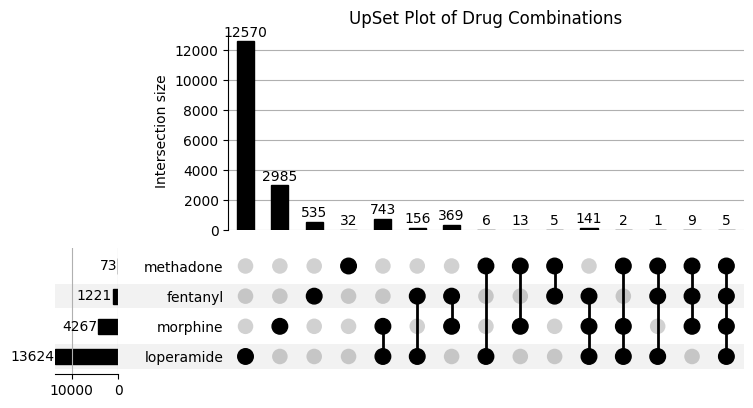

In [33]:
# Upset plot
# Create sets for each drug
loperamide_set = set(pandas_df_loperamide["eid"].unique())
methadone_set = set(pandas_df_methadone["eid"].unique())
fentanyl_set = set(pandas_df_fentanyl["eid"].unique())
morphine_set = set(pandas_df_morphine["eid"].unique())

# Combine all the sets to get a list of unique 'eid's
all_eids = list(loperamide_set.union(methadone_set, fentanyl_set, morphine_set))

# Now, create a binary DataFrame where each row represents an `eid` and each column is a drug
binary_data = {
    "loperamide": [1 if eid in loperamide_set else 0 for eid in all_eids],
    "methadone": [1 if eid in methadone_set else 0 for eid in all_eids],
    "fentanyl": [1 if eid in fentanyl_set else 0 for eid in all_eids],
    "morphine": [1 if eid in morphine_set else 0 for eid in all_eids],
}

# Create a DataFrame from the binary data
drug_combinations = pd.DataFrame(binary_data, index=all_eids)

# Use the UpSetPlot package to visualize the drug combinations
upset_data = drug_combinations.groupby(list(binary_data.keys())).size()

# Create the UpSet plot
upset = UpSet(upset_data, show_counts=True, show_percentages=False)
plt.figure(figsize=(12, 8))
upset.plot()
plt.title("UpSet Plot of Drug Combinations")
plt.show()

Start with morphine

In [34]:
df_morphine_sorted = pandas_df_morphine.sort_values(by="issue_date")
morphine_groupbyeid = (
    df_morphine_sorted.groupby("eid")
    .agg(
        num_issuedates=("issue_date", "nunique"),
        issue_dates=("issue_date", list),
        quantities=("quantity", list),
        quantities_mg=("quantity_mg", list),
    )
    .reset_index()
)
display(morphine_groupbyeid.drop("eid", axis=1))

,num_issuedates,issue_dates,quantities,quantities_mg
0,2,"[2013-02-06, 2013-02-11]","[100 millilitres, 2 packs of 100 mls]","[200.0, 400.0]"
1,1,[2008-07-31],[56.000],[1120.0]
2,18,"[2013-04-08, 2013-04-08, 2013-04-19, 2013-04-1...","[100 millilitres, 56 tablets, 100 millilitres,...","[200.0, 560.0, 200.0, 560.0, 200.0, 200.0, 560..."
3,2,"[2015-09-11, 2015-09-18]","[100 ml, 200 ml]","[200.0, 400.0]"
4,3,"[2015-07-15, 2015-08-05, 2015-08-26]","[100 ml, 100 ml, 60 capsule]","[200.0, 200.0, 600.0]"
...,...,...,...,...
4262,2,"[2013-09-13, 2014-05-23]","[300 millilitres, 2 packs of 100 mls]","[600.0, 400.0]"
4263,2,"[2016-05-05, 2016-05-09]","[10 ampoule, 10 ampoule]","[100.0, 100.0]"
4264,25,"[2010-03-01, 2010-03-03, 2010-03-09, 2010-03-0...","[200 mls, 14 cap, 200 mls, 120 cap, 200 mls, 1...","[400.0, 140.0, 400.0, 3600.0, 400.0, 3600.0, 3..."
4265,1,[2008-09-02],[60 - tablet(s)],[1800.0]


In [35]:
# Function to process each row
def process_row(row):
    # Remove duplicates while preserving the order using dict.fromkeys
    unique_dates = list(
        dict.fromkeys(row["issue_dates"])
    )  # Preserves order and removes duplicates
    num_issuedates = len(unique_dates)  # Update the num_issuedates column

    # Initialize empty lists for new quantities and mg values
    new_quantities = []
    new_quantities_mg = []

    # Create a dictionary to sum quantities and mg for each unique date
    date_dict = {}
    for i, date in enumerate(row["issue_dates"]):
        mg_value = row["quantities_mg"][i]
        qty_value = row["quantities"][i]

        if date not in date_dict:
            date_dict[date] = {"quantities": [], "mg": 0, "quantity_str": []}

        # Add quantity and mg for the same date
        if qty_value:  # Only process valid quantities
            date_dict[date]["quantities"].append(qty_value)
            date_dict[date]["mg"] += mg_value
            date_dict[date]["quantity_str"].append(
                str(qty_value)
            )  # Ensure it's a string

    # Process the date_dict to generate the new lists
    for date in unique_dates:
        date_info = date_dict[date]
        # Combine quantities as a string with 'and' between them
        new_qty = " and ".join(date_info["quantity_str"])
        new_quantities.append(new_qty)
        new_quantities_mg.append(date_info["mg"])

    # Return the updated row with processed data
    return pd.Series(
        {
            "eid": row["eid"],
            "num_issuedates": num_issuedates,
            "issue_dates": unique_dates,
            "quantities": new_quantities,
            "quantities_mg": new_quantities_mg,
        }
    )


# Apply the function to process the DataFrame
morphine_groupbyeid = morphine_groupbyeid.apply(process_row, axis=1)

# Display the processed DataFrame
display(morphine_groupbyeid.drop("eid", axis=1))

,num_issuedates,issue_dates,quantities,quantities_mg
0,2,"[2013-02-06, 2013-02-11]","[100 millilitres, 2 packs of 100 mls]","[200.0, 400.0]"
1,1,[2008-07-31],[56.000],[1120.0]
2,18,"[2013-04-08, 2013-04-19, 2013-04-29, 2013-05-1...","[100 millilitres and 56 tablets, 100 millilitr...","[760.0, 760.0, 200.0, 200.0, 560.0, 200.0, 200..."
3,2,"[2015-09-11, 2015-09-18]","[100 ml, 200 ml]","[200.0, 400.0]"
4,3,"[2015-07-15, 2015-08-05, 2015-08-26]","[100 ml, 100 ml, 60 capsule]","[200.0, 200.0, 600.0]"
...,...,...,...,...
4262,2,"[2013-09-13, 2014-05-23]","[300 millilitres, 2 packs of 100 mls]","[600.0, 400.0]"
4263,2,"[2016-05-05, 2016-05-09]","[10 ampoule, 10 ampoule]","[100.0, 100.0]"
4264,25,"[2010-03-01, 2010-03-03, 2010-03-09, 2010-03-2...","[200 mls, 14 cap, 200 mls and 120 cap, 200 mls...","[400.0, 140.0, 4000.0, 400.0, 3600.0, 3600.0, ..."
4265,1,[2008-09-02],[60 - tablet(s)],[1800.0]


In [36]:
# Calculate treatment duration (difference between the first and last issue date)
morphine_groupbyeid["treatment_duration_days"] = morphine_groupbyeid[
    "issue_dates"
].apply(lambda x: (max(x) - min(x)).days if len(x) > 1 else 0)
print("Summary of treatment_duration_days:")
print(morphine_groupbyeid["treatment_duration_days"].describe())

# Calculate total quantities in mg
morphine_groupbyeid["total_quantity_mg"] = morphine_groupbyeid["quantities_mg"].apply(
    sum
)
print("Summary of total_quantity_mg:")
print(morphine_groupbyeid["total_quantity_mg"].describe())


# Calculate gap days between issue dates
def calculate_gap_days(dates):
    if len(dates) > 1:
        return [(dates[i + 1] - dates[i]).days for i in range(len(dates) - 1)]
    else:
        return []


morphine_groupbyeid["gap_days"] = morphine_groupbyeid["issue_dates"].apply(
    calculate_gap_days
)


# Calculate adherence (quantity/day) for each issue
def calculate_adherence_per_issue(quantities, dates):
    if len(dates) > 1:
        durations = [(dates[i + 1] - dates[i]).days for i in range(len(dates) - 1)]
        return [
            quantities[i] / durations[i] if durations[i] > 0 else None
            for i in range(len(durations))
        ]
    else:
        return []

# Calculate average per issue
morphine_groupbyeid["adherence_per_issue"] = morphine_groupbyeid.apply(
    lambda row: calculate_adherence_per_issue(row["quantities_mg"], row["issue_dates"]),
    axis=1,
)

# Average adherence per participant (ignoring NaN)
morphine_groupbyeid["average_adherence"] = morphine_groupbyeid[
    "adherence_per_issue"
].apply(lambda x: np.nanmean(x))
# Calculate the standard deviation of average_adherence to assess variability:
morphine_groupbyeid["adherence_std"] = morphine_groupbyeid["adherence_per_issue"].apply(
    lambda x: np.nanstd(x)
)

display(morphine_groupbyeid.drop("eid", axis=1))

Summary of treatment_duration_days:
count    4267.000000
mean      318.443637
std       752.085666
min         0.000000
25%         0.000000
50%        16.000000
75%       197.000000
max      7624.000000
Name: treatment_duration_days, dtype: float64
Summary of total_quantity_mg:
count    4.263000e+03
mean     8.692932e+03
std      4.657681e+04
min      0.000000e+00
25%      4.000000e+02
50%      8.000000e+02
75%      2.760000e+03
max      1.496840e+06
Name: total_quantity_mg, dtype: float64


/tmp/ipykernel_86/4166276909.py:49: RuntimeWarning: Mean of empty slice
  ].apply(lambda x: np.nanmean(x))
/opt/conda/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1878: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,


,num_issuedates,issue_dates,quantities,quantities_mg,treatment_duration_days,total_quantity_mg,gap_days,adherence_per_issue,average_adherence,adherence_std
0,2,"[2013-02-06, 2013-02-11]","[100 millilitres, 2 packs of 100 mls]","[200.0, 400.0]",5,600.0,[5],[40.0],40.000000,0.000000
1,1,[2008-07-31],[56.000],[1120.0],0,1120.0,[],[],NaN,NaN
2,18,"[2013-04-08, 2013-04-19, 2013-04-29, 2013-05-1...","[100 millilitres and 56 tablets, 100 millilitr...","[760.0, 760.0, 200.0, 200.0, 560.0, 200.0, 200...",333,6400.0,"[11, 10, 15, 1, 13, 7, 20, 28, 25, 7, 18, 20, ...","[69.0909090909091, 76.0, 13.333333333333334, 2...",37.196214,47.466134
3,2,"[2015-09-11, 2015-09-18]","[100 ml, 200 ml]","[200.0, 400.0]",7,600.0,[7],[28.571428571428573],28.571429,0.000000
4,3,"[2015-07-15, 2015-08-05, 2015-08-26]","[100 ml, 100 ml, 60 capsule]","[200.0, 200.0, 600.0]",42,1000.0,"[21, 21]","[9.523809523809524, 9.523809523809524]",9.523810,0.000000
...,...,...,...,...,...,...,...,...,...,...
4262,2,"[2013-09-13, 2014-05-23]","[300 millilitres, 2 packs of 100 mls]","[600.0, 400.0]",252,1000.0,[252],[2.380952380952381],2.380952,0.000000
4263,2,"[2016-05-05, 2016-05-09]","[10 ampoule, 10 ampoule]","[100.0, 100.0]",4,200.0,[4],[25.0],25.000000,0.000000
4264,25,"[2010-03-01, 2010-03-03, 2010-03-09, 2010-03-2...","[200 mls, 14 cap, 200 mls and 120 cap, 200 mls...","[400.0, 140.0, 4000.0, 400.0, 3600.0, 3600.0, ...",169,30080.0,"[2, 6, 13, 7, 15, 10, 33, 7, 7, 6, 7, 2, 5, 2,...","[200.0, 23.333333333333332, 307.6923076923077,...",239.333500,182.878100
4265,1,[2008-09-02],[60 - tablet(s)],[1800.0],0,1800.0,[],[],NaN,NaN


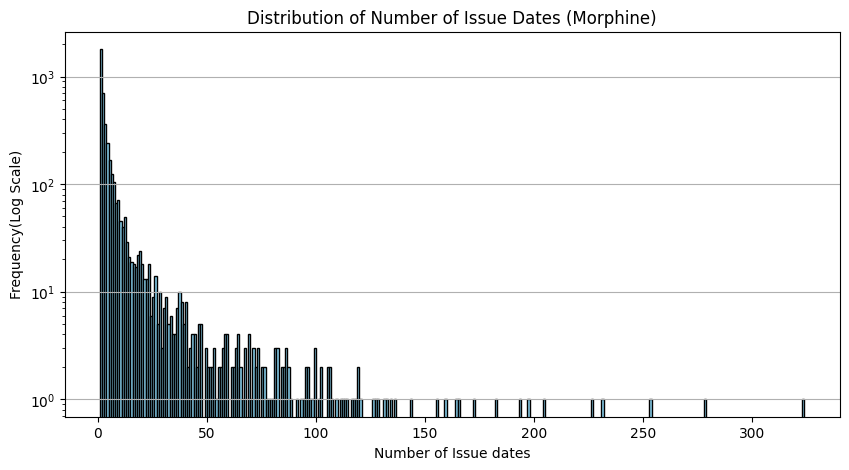

In [37]:
# Visualize number of issue dates
plt.figure(figsize=(10, 5))
plt.hist(
    morphine_groupbyeid["num_issuedates"],
    bins=range(1, morphine_groupbyeid["num_issuedates"].max() + 2),
    color="skyblue",
    edgecolor="black",
)
plt.title("Distribution of Number of Issue Dates (Morphine)")
plt.xlabel("Number of Issue dates")
plt.ylabel("Frequency(Log Scale)")
plt.yscale("log")  # Logarithmic scale for y-axis
plt.grid(axis="y")
plt.show()

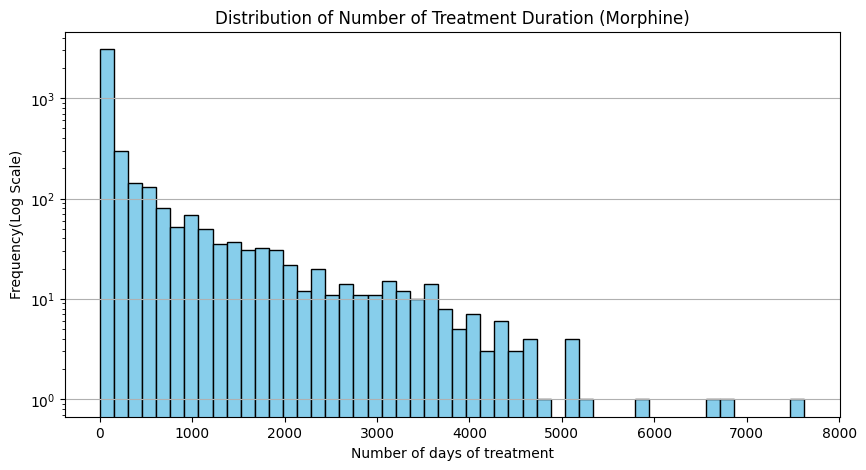

In [38]:
# Visualize treatment duration
plt.figure(figsize=(10, 5))
plt.hist(
    morphine_groupbyeid["treatment_duration_days"],
    bins=50,
    color="skyblue",
    edgecolor="black",
)
plt.title("Distribution of Number of Treatment Duration (Morphine)")
plt.xlabel("Number of days of treatment")
plt.ylabel("Frequency(Log Scale)")
plt.yscale("log")  # Logarithmic scale for y-axis
plt.grid(axis="y")
plt.show()

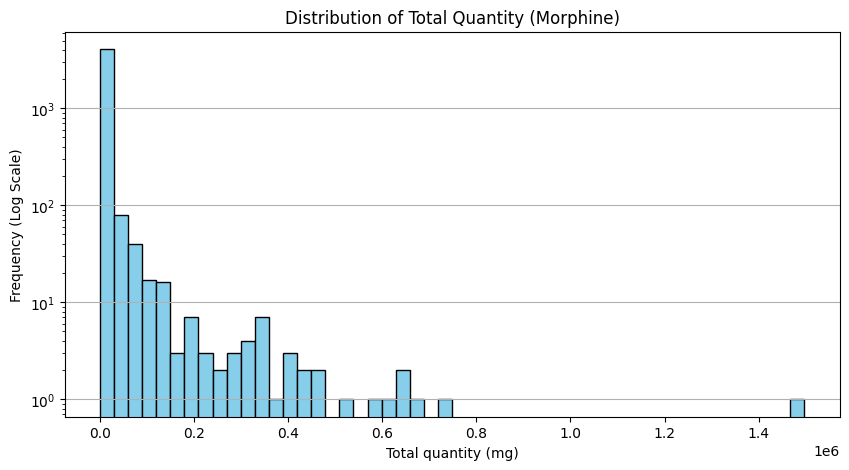

In [39]:
# Visualize total quantity_mg
plt.figure(figsize=(10, 5))
plt.hist(
    morphine_groupbyeid["total_quantity_mg"],
    bins=50,
    color="skyblue",
    edgecolor="black",
)
plt.yscale("log")  # Logarithmic scale for y-axis
plt.title("Distribution of Total Quantity (Morphine)")
plt.xlabel("Total quantity (mg)")
plt.ylabel("Frequency (Log Scale)")
plt.grid(axis="y")

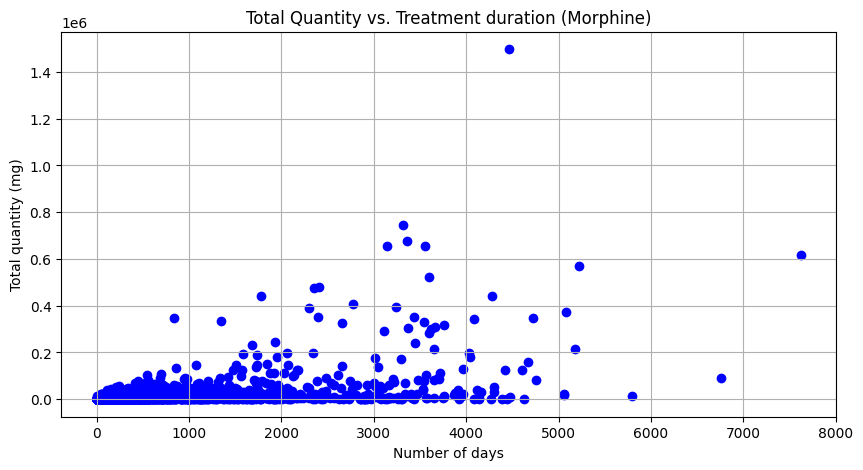

In [40]:
# Scatter Plot: : Correlation between treatment durantion and total_quantity_mg
plt.figure(figsize=(10, 5))
plt.scatter(
    morphine_groupbyeid["treatment_duration_days"],
    morphine_groupbyeid["total_quantity_mg"],
    c="blue",
)
plt.title("Total Quantity vs. Treatment duration (Morphine)")
plt.xlabel("Number of days")
plt.ylabel("Total quantity (mg)")
plt.grid()
plt.show()

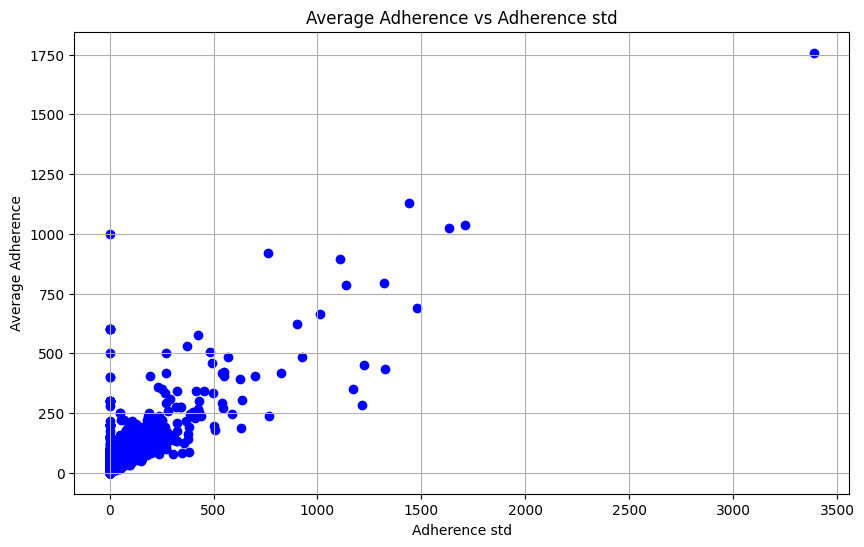

In [41]:
# Scatter Plot: Average_adherence vs Adherence_std
plt.figure(figsize=(10, 6))
plt.scatter(
    morphine_groupbyeid["adherence_std"],
    morphine_groupbyeid["average_adherence"],
    c="blue",
)
plt.title("Average Adherence vs Adherence std")
plt.xlabel("Adherence std")
plt.ylabel("Average Adherence")
plt.grid()
plt.show()

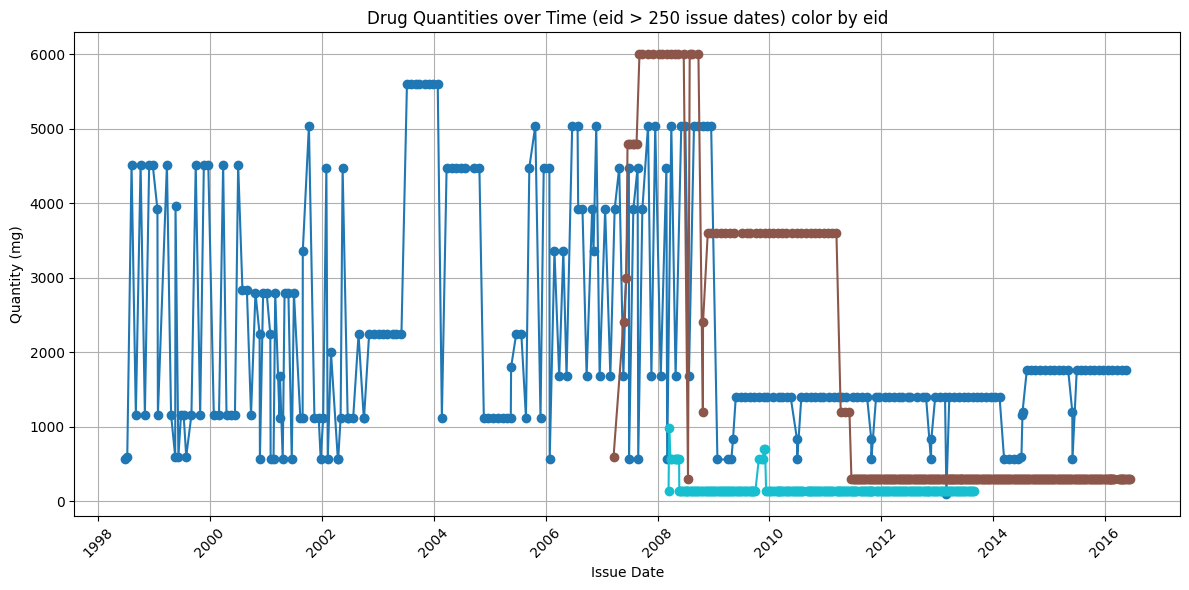

In [42]:
# Plot Drug Quantities over Time
# Filter rows where num_issuedates > 250
filtered_data_250 = morphine_groupbyeid[morphine_groupbyeid["num_issuedates"] > 250]

# Set up the plot
plt.figure(figsize=(12, 6))

# Generate a colormap with enough colors for all unique eids
unique_eids = filtered_data_250.index  # Assuming `eid` is the index
colors = cm.get_cmap("tab10", len(unique_eids))

# Loop through each row and plot
for i, (eid, row) in enumerate(filtered_data_250.iterrows()):
    # Sort the data by issue_dates to ensure lines are properly connected
    sorted_dates, sorted_quantities = zip(*sorted(zip(row["issue_dates"], row["quantities_mg"])))

    # Plot the line connecting points for this eid
    plt.plot(sorted_dates, sorted_quantities, marker='o', color=colors(i))

# Add titles and labels
plt.title("Drug Quantities over Time (eid > 250 issue dates) color by eid")
plt.xlabel("Issue Date")
plt.ylabel("Quantity (mg)")
plt.xticks(rotation=45)
plt.grid(True)

# Show the plot
plt.tight_layout()
plt.show()

Calculate a Adherence Study score: df['adherence_score'] = (
    df['treatment_duration_days'] + # More days more adherence
    (df['num_issuedates']) + # More issues more adherence
    (df['average_adherence']) -  # More mg/day more adherence
    (df['adherence_std'])  # Lower variability more adherence
)

Summary of adherence_score with more than 1 issue date:
count    2471.000000
mean        0.551250
std         2.207236
min        -5.693469
25%        -0.595128
50%        -0.254528
75%         0.674324
max        20.438632
Name: adherence_score_prescription, dtype: float64


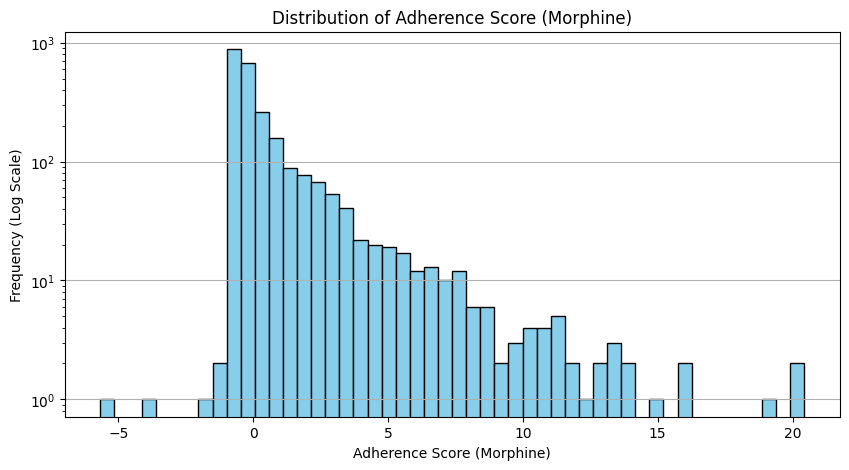

In [43]:
# Include adherence score for Morphine normalizing each feature:
# Initialize the scaler
scaler = StandardScaler()
morphine_groupbyeid["adherence_score_prescription"] = (
    scaler.fit_transform(
        morphine_groupbyeid["treatment_duration_days"].values.reshape(-1, 1)
    )
    + scaler.fit_transform(morphine_groupbyeid["num_issuedates"].values.reshape(-1, 1))
    + scaler.fit_transform(
        morphine_groupbyeid["average_adherence"].values.reshape(-1, 1)
    )
    - scaler.fit_transform(morphine_groupbyeid["adherence_std"].values.reshape(-1, 1))
)
print("Summary of adherence_score with more than 1 issue date:")
print(morphine_groupbyeid[morphine_groupbyeid["num_issuedates"] > 1]["adherence_score_prescription"].describe())

# Distribution of adherence score for people with more than 1 issue date
plt.figure(figsize=(10, 5))
plt.hist(
    morphine_groupbyeid[morphine_groupbyeid["num_issuedates"] > 1][
        "adherence_score_prescription"
    ],
    bins=50,
    color="skyblue",
    edgecolor="black",
)
plt.title("Distribution of Adherence Score (Morphine)")
plt.xlabel("Adherence Score (Morphine)")
plt.ylabel("Frequency (Log Scale)")
plt.yscale("log")  # Logarithmic scale for y-axis
plt.grid(axis="y")
plt.show()

In [44]:
morphine_groupbyeid.to_csv("prescription_morphine_groupbyeid.csv", index=False)
display(morphine_groupbyeid.drop("eid", axis=1))

,num_issuedates,issue_dates,quantities,quantities_mg,treatment_duration_days,total_quantity_mg,gap_days,adherence_per_issue,average_adherence,adherence_std,adherence_score_prescription
0,2,"[2013-02-06, 2013-02-11]","[100 millilitres, 2 packs of 100 mls]","[200.0, 400.0]",5,600.0,[5],[40.0],40.000000,0.000000,-0.524090
1,1,[2008-07-31],[56.000],[1120.0],0,1120.0,[],[],NaN,NaN,NaN
2,18,"[2013-04-08, 2013-04-19, 2013-04-29, 2013-05-1...","[100 millilitres and 56 tablets, 100 millilitr...","[760.0, 760.0, 200.0, 200.0, 560.0, 200.0, 200...",333,6400.0,"[11, 10, 15, 1, 13, 7, 20, 28, 25, 7, 18, 20, ...","[69.0909090909091, 76.0, 13.333333333333334, 2...",37.196214,47.466134,0.379887
3,2,"[2015-09-11, 2015-09-18]","[100 ml, 200 ml]","[200.0, 400.0]",7,600.0,[7],[28.571428571428573],28.571429,0.000000,-0.643105
4,3,"[2015-07-15, 2015-08-05, 2015-08-26]","[100 ml, 100 ml, 60 capsule]","[200.0, 200.0, 600.0]",42,1000.0,"[21, 21]","[9.523809523809524, 9.523809523809524]",9.523810,0.000000,-0.746986
...,...,...,...,...,...,...,...,...,...,...,...
4262,2,"[2013-09-13, 2014-05-23]","[300 millilitres, 2 packs of 100 mls]","[600.0, 400.0]",252,1000.0,[252],[2.380952380952381],2.380952,0.000000,-0.596143
4263,2,"[2016-05-05, 2016-05-09]","[10 ampoule, 10 ampoule]","[100.0, 100.0]",4,200.0,[4],[25.0],25.000000,0.000000,-0.685118
4264,25,"[2010-03-01, 2010-03-03, 2010-03-09, 2010-03-2...","[200 mls, 14 cap, 200 mls and 120 cap, 200 mls...","[400.0, 140.0, 4000.0, 400.0, 3600.0, 3600.0, ...",169,30080.0,"[2, 6, 13, 7, 15, 10, 33, 7, 7, 6, 7, 2, 5, 2,...","[200.0, 23.333333333333332, 307.6923076923077,...",239.333500,182.878100,1.709866
4265,1,[2008-09-02],[60 - tablet(s)],[1800.0],0,1800.0,[],[],NaN,NaN,NaN


## Comparison OMOP era and gp_scripts EDA

In [45]:
# Count distinct `eid` values for each drug in prescription data
print("The number of distinct `eid` values for loperamide is:")
print(pandas_df_loperamide["eid"].nunique())
print("The number of distinct `eid` values for methadone is:")
print(pandas_df_methadone["eid"].nunique())
print("The number of distinct `eid` values for fentanyl is:")
print(pandas_df_fentanyl["eid"].nunique())
print("The number of distinct `eid` values for morphine is:")
print(pandas_df_morphine["eid"].nunique())

The number of distinct `eid` values for loperamide is:
13624
The number of distinct `eid` values for methadone is:
73
The number of distinct `eid` values for fentanyl is:
1221
The number of distinct `eid` values for morphine is:
4267


In the OMOP database I found this:          
drug  count
loperamide:  15660,
morphine:   7217,
fentanyl:   1684,
methadone:     82,

Not exactly the same

Now let see why this results are diferent from OMOP taking for example the morphine, that have 7217 user in OMOP database and 4370 in the prescriptions database

In [46]:
# Load the CSV file of Omap data as a DataFrame
omap_data = pd.read_csv("filtered_data_era.csv")

In [47]:
omap_data_morphine = omap_data[omap_data["drug"] == "morphine"]
# Convert the 'eid' arrays to sets
pandas_eids_morphine = set(pandas_df_morphine["eid"].astype(int).unique())
omap_eids_morphine = set(omap_data_morphine["eid"].astype(int).unique())

# Find the common 'eid' values (intersection)
common_eids_morphine = pandas_eids_morphine.intersection(omap_eids_morphine)

# Find the 'eid' values that are in pandas_df_morphine but not in omap_data_morphine
only_in_pandas_morphine = pandas_eids_morphine.difference(omap_eids_morphine)

# Find the 'eid' values that are in omap_data_morphine but not in pandas_df_morphine
only_in_omap_morphine = omap_eids_morphine.difference(pandas_eids_morphine)

# Print the number of common and distinct 'eid' values
print(f"Number of common eids morphine: {len(common_eids_morphine)}")
print(f"Number of eids only in pandas_df_morphine: {len(only_in_pandas_morphine)}")
print(f"Number of eids only in omap_data_morphine: {len(only_in_omap_morphine)}")


Number of common eids morphine: 4266
Number of eids only in pandas_df_morphine: 1
Number of eids only in omap_data_morphine: 2951


So there are a lot of eid that contains information in OMAP era but not in prescription data: This is because gp_scripts write the drug names in very different forms so not all of the prescriptions are really captured and OMOP era capture the Ingredient. Also there is 1 eid that contains information only in gp_scripts, that could be because this database is constantly renewed.

Let's do the same with the other drugs

In [48]:
omap_data_loperamide = omap_data[omap_data["drug"] == "loperamide"]
# Convert the 'eid' arrays to sets
pandas_eids_loperamide = set(pandas_df_loperamide["eid"].astype(int).unique())
omap_eids_loperamide = set(omap_data_loperamide["eid"].astype(int).unique())

# Find the common 'eid' values (intersection)
common_eids_loperamide = pandas_eids_loperamide.intersection(omap_eids_loperamide)

# Find the 'eid' values that are in pandas_df_loperamide but not in omap_data_loperamide
only_in_pandas_loperamide = pandas_eids_loperamide.difference(omap_eids_loperamide)

# Find the 'eid' values that are in omap_data_loperamide but not in pandas_df_loperamide
only_in_omap_loperamide = omap_eids_loperamide.difference(pandas_eids_loperamide)

# Print the number of common and distinct 'eid' values
print(f"Number of common eids loperamide: {len(common_eids_loperamide)}")
print(f"Number of eids only in pandas_df_loperamide: {len(only_in_pandas_loperamide)}")
print(f"Number of eids only in omap_data_loperamide: {len(only_in_omap_loperamide)}")

Number of common eids loperamide: 13608
Number of eids only in pandas_df_loperamide: 16
Number of eids only in omap_data_loperamide: 2052


In [49]:
omap_data_fentanyl = omap_data[omap_data["drug"] == "fentanyl"]
# Convert the 'eid' arrays to sets
pandas_eids_fentanyl = set(pandas_df_fentanyl["eid"].astype(int).unique())
omap_eids_fentanyl = set(omap_data_fentanyl["eid"].astype(int).unique())

# Find the common 'eid' values (intersection)
common_eids_fentanyl = pandas_eids_fentanyl.intersection(omap_eids_fentanyl)

# Find the 'eid' values that are in pandas_df_fentanyl but not in omap_data_fentanyl
only_in_pandas_fentanyl = pandas_eids_fentanyl.difference(omap_eids_fentanyl)

# Find the 'eid' values that are in omap_data_fentanyl but not in pandas_df_fentanyl
only_in_omap_fentanyl = omap_eids_fentanyl.difference(pandas_eids_fentanyl)

# Print the number of common and distinct 'eid' values
print(f"Number of common eids fentanyl: {len(common_eids_fentanyl)}")
print(f"Number of eids only in pandas_df_fentanyl: {len(only_in_pandas_fentanyl)}")
print(f"Number of eids only in omap_data_fentanyl: {len(only_in_omap_fentanyl)}")

Number of common eids fentanyl: 1221
Number of eids only in pandas_df_fentanyl: 0
Number of eids only in omap_data_fentanyl: 463


In [50]:
omap_data_methadone = omap_data[omap_data["drug"] == "methadone"]
# Convert the 'eid' arrays to sets
pandas_eids_methadone = set(pandas_df_methadone["eid"].astype(int).unique())
omap_eids_methadone = set(omap_data_methadone["eid"].astype(int).unique())

# Find the common 'eid' values (intersection)
common_eids_methadone = pandas_eids_methadone.intersection(omap_eids_methadone)

# Find the 'eid' values that are in pandas_df_methadone but not in omap_data_methadone
only_in_pandas_methadone = pandas_eids_methadone.difference(omap_eids_methadone)

# Find the 'eid' values that are in omap_data_methadone but not in pandas_df_methadone
only_in_omap_methadone = omap_eids_methadone.difference(pandas_eids_methadone)

# Print the number of common and distinct 'eid' values
print(f"Number of common eids methadone: {len(common_eids_methadone)}")
print(f"Number of eids only in pandas_df_methadone: {len(only_in_pandas_methadone)}")
print(f"Number of eids only in omap_data_methadone: {len(only_in_omap_methadone)}")

Number of common eids methadone: 72
Number of eids only in pandas_df_methadone: 1
Number of eids only in omap_data_methadone: 10


Now I will compare both omap and prescription group by eid dataframes of morphine

In [51]:
# Load the CSV file of Omap data as a DataFrame
omop_morphine_groupbyeid = pd.read_csv("omop_morphine_groupbyeid.csv")
prec_morphine_groupbyeid = morphine_groupbyeid
omop_morphine_groupbyeid['eid'] = omop_morphine_groupbyeid['eid'].astype(str)
prec_morphine_groupbyeid['eid'] = prec_morphine_groupbyeid['eid'].astype(str)
# Merge the dataframes on 'eid', keeping only the rows with common eids
merged_df = pd.merge(
    omop_morphine_groupbyeid, prec_morphine_groupbyeid, on="eid", how="inner"
)
# Display the merged dataframe
display(merged_df.drop("eid", axis=1))

,num_drug_era_id,start_dates,end_dates,exposure_counts,gap_days_x,total_exposure_counts,exposure_counts_std,start_dates_parsed,end_dates_parsed,total_duration,...,issue_dates,quantities,quantities_mg,treatment_duration_days,total_quantity_mg,gap_days_y,adherence_per_issue,average_adherence,adherence_std,adherence_score_prescription
0,1,['2013-02-06'],['2013-03-12'],[2],[0],2,0.0,"DatetimeIndex(['2013-02-06'], dtype='datetime6...","DatetimeIndex(['2013-03-12'], dtype='datetime6...",34,...,"[2013-02-06, 2013-02-11]","[100 millilitres, 2 packs of 100 mls]","[200.0, 400.0]",5,600.0,[5],[40.0],40.000000,0.000000,-0.524090
1,1,['2008-07-31'],['2008-08-11'],[1],[0],1,0.0,"DatetimeIndex(['2008-07-31'], dtype='datetime6...","DatetimeIndex(['2008-08-11'], dtype='datetime6...",11,...,[2008-07-31],[56.000],[1120.0],0,1120.0,[],[],NaN,NaN,NaN
2,1,['2013-04-08'],['2014-04-05'],[51],[37],51,0.0,"DatetimeIndex(['2013-04-08'], dtype='datetime6...","DatetimeIndex(['2014-04-05'], dtype='datetime6...",362,...,"[2013-04-08, 2013-04-19, 2013-04-29, 2013-05-1...","[100 millilitres and 56 tablets, 100 millilitr...","[760.0, 760.0, 200.0, 200.0, 560.0, 200.0, 200...",333,6400.0,"[11, 10, 15, 1, 13, 7, 20, 28, 25, 7, 18, 20, ...","[69.0909090909091, 76.0, 13.333333333333334, 2...",37.196214,47.466134,0.379887
3,1,['2015-09-11'],['2015-10-17'],[2],[0],2,0.0,"DatetimeIndex(['2015-09-11'], dtype='datetime6...","DatetimeIndex(['2015-10-17'], dtype='datetime6...",36,...,"[2015-09-11, 2015-09-18]","[100 ml, 200 ml]","[200.0, 400.0]",7,600.0,[7],[28.571428571428573],28.571429,0.000000,-0.643105
4,1,['2015-07-15'],['2015-09-03'],[3],[0],3,0.0,"DatetimeIndex(['2015-07-15'], dtype='datetime6...","DatetimeIndex(['2015-09-03'], dtype='datetime6...",50,...,"[2015-07-15, 2015-08-05, 2015-08-26]","[100 ml, 100 ml, 60 capsule]","[200.0, 200.0, 600.0]",42,1000.0,"[21, 21]","[9.523809523809524, 9.523809523809524]",9.523810,0.000000,-0.746986
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4261,3,"['2013-09-13', '2013-12-23', '2014-05-23']","['2013-10-12', '2014-01-21', '2014-06-21']","[1, 1, 1]","[0, 0, 0]",3,0.0,"DatetimeIndex(['2013-09-13', '2013-12-23', '20...","DatetimeIndex(['2013-10-12', '2014-01-21', '20...",281,...,"[2013-09-13, 2014-05-23]","[300 millilitres, 2 packs of 100 mls]","[600.0, 400.0]",252,1000.0,[252],[2.380952380952381],2.380952,0.000000,-0.596143
4262,1,['2016-05-05'],['2016-06-07'],[2],[0],2,0.0,"DatetimeIndex(['2016-05-05'], dtype='datetime6...","DatetimeIndex(['2016-06-07'], dtype='datetime6...",33,...,"[2016-05-05, 2016-05-09]","[10 ampoule, 10 ampoule]","[100.0, 100.0]",4,200.0,[4],[25.0],25.000000,0.000000,-0.685118
4263,2,"['2010-03-01', '2010-12-01']","['2010-09-11', '2011-01-12']","[28, 11]","[4, 0]",39,8.5,"DatetimeIndex(['2010-03-01', '2010-12-01'], dt...","DatetimeIndex(['2010-09-11', '2011-01-12'], dt...",317,...,"[2010-03-01, 2010-03-03, 2010-03-09, 2010-03-2...","[200 mls, 14 cap, 200 mls and 120 cap, 200 mls...","[400.0, 140.0, 4000.0, 400.0, 3600.0, 3600.0, ...",169,30080.0,"[2, 6, 13, 7, 15, 10, 33, 7, 7, 6, 7, 2, 5, 2,...","[200.0, 23.333333333333332, 307.6923076923077,...",239.333500,182.878100,1.709866
4264,1,['2008-09-02'],['2008-09-19'],[1],[0],1,0.0,"DatetimeIndex(['2008-09-02'], dtype='datetime6...","DatetimeIndex(['2008-09-19'], dtype='datetime6...",17,...,[2008-09-02],[60 - tablet(s)],[1800.0],0,1800.0,[],[],NaN,NaN,NaN


We can see that many start dates in omap match wiht the first issue date in gp_scripts, however omop_era have more prescriptions because it taking in account the ingredient not just the name of the drug like gp_scripts that is why we can not see a total coincidence

In [52]:
merged_df.to_csv("omop_era_prescription_merge.csv", index=False)

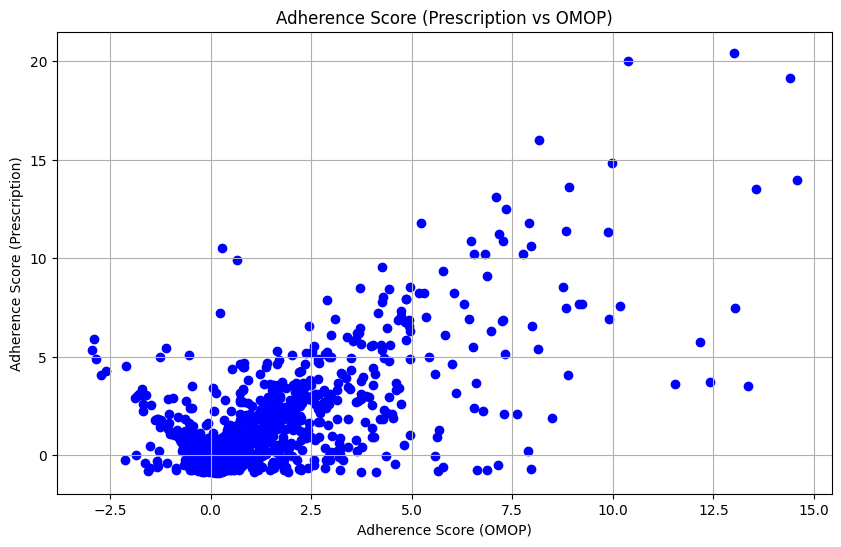

In [53]:
# Scatter Plot: prec_adherence_score vs omop_adherence_score
plt.figure(figsize=(10, 6))
plt.scatter(
    merged_df["adherence_score_omop"],
    merged_df["adherence_score_prescription"],
    c="blue",
)
plt.title("Adherence Score (Prescription vs OMOP)")
plt.xlabel("Adherence Score (OMOP)")
plt.ylabel("Adherence Score (Prescription)")
plt.grid()
plt.show()

It looks like there is a correlation between scores

## Comparison OMOP exposure and gp_scripts EDA for morphine

In [55]:
# Load the CSV file of Omop data as a DataFrame
omap_data_exposure_morphine = pd.read_csv("filtered_data_exposure_morphine.csv")
# Convert the 'eid' arrays to sets
pandas_eids_morphine = set(pandas_df_morphine["eid"].astype(int).unique())
omap_exposure_eids_morphine = set(omap_data_exposure_morphine["eid"].astype(int).unique())

# Find the common 'eid' values (intersection)
common_eids_morphine = pandas_eids_morphine.intersection(omap_exposure_eids_morphine)

# Find the 'eid' values that are in pandas_df_morphine but not in omap_data_morphine
only_in_pandas_morphine = pandas_eids_morphine.difference(omap_exposure_eids_morphine)

# Find the 'eid' values that are in omap_data_morphine but not in pandas_df_morphine
only_in_omap_morphine = omap_exposure_eids_morphine.difference(pandas_eids_morphine)

# Print the number of common and distinct 'eid' values
print(f"Number of common eids morphine: {len(common_eids_morphine)}")
print(f"Number of eids only in gp_scripts: {len(only_in_pandas_morphine)}")
print(f"Number of eids only in omap exposure: {len(only_in_omap_morphine)}")


Number of common eids morphine: 3886
Number of eids only in gp_scripts: 381
Number of eids only in omap exposure: 78


We can see that in this case there are more eid only gp_scripts, let see if we merge both what we see:

In [56]:
prec_morphine_groupbyeid = morphine_groupbyeid
omop_exposure_morphine_sorted = omap_data_exposure_morphine.sort_values(by="drug_exposure_start_date")
omop_exposure_groupbyeid = (
    omop_exposure_morphine_sorted.groupby("eid")
    .agg(
        num_exposures=("drug_exposure_start_date", "nunique"),
        drug_exposure_start_dates=("drug_exposure_start_date", list),
        drug_exposure_end_dates=("drug_exposure_end_date", list),
        refills=("refills", list),
        days_supply=("days_supply", list),
        quantities=("quantity", list)
    )
    .reset_index()
)
display(omop_exposure_groupbyeid.drop("eid", axis=1))

,num_exposures,drug_exposure_start_dates,drug_exposure_end_dates,refills,days_supply,quantities
0,2,"[2013-02-06, 2013-02-11]","[2013-03-07, 2013-03-12]","[nan, nan]","[nan, nan]","[100.0, 2.0]"
1,18,"[2013-04-08, 2013-04-08, 2013-04-19, 2013-04-1...","[2013-04-13, 2013-05-07, 2013-05-18, 2013-04-2...","[nan, nan, nan, nan, nan, nan, nan, nan, nan, ...","[nan, nan, nan, nan, nan, nan, nan, nan, nan, ...","[56.0, 100.0, 100.0, 56.0, 100.0, 100.0, 56.0,..."
2,2,"[2015-09-11, 2015-09-18]","[2015-10-10, 2015-10-17]","[nan, nan]","[nan, nan]","[100.0, 200.0]"
3,3,"[2015-07-15, 2015-08-05, 2015-08-26]","[2015-08-13, 2015-09-03, 2015-08-31]","[nan, nan, nan]","[nan, nan, nan]","[100.0, 100.0, 60.0]"
4,6,"[2014-04-02, 2014-04-17, 2014-05-07, 2014-05-2...","[2014-05-01, 2014-05-16, 2014-06-05, 2014-06-2...","[nan, nan, nan, nan, nan, nan]","[nan, nan, nan, nan, nan, nan]","[100.0, 300.0, 300.0, 300.0, 300.0, 300.0]"
...,...,...,...,...,...,...
3959,2,"[2013-09-13, 2014-05-23]","[2013-10-12, 2014-06-21]","[nan, nan]","[nan, nan]","[300.0, 2.0]"
3960,2,"[2016-05-05, 2016-05-09]","[2016-06-03, 2016-06-07]","[nan, nan]","[nan, nan]","[10.0, 10.0]"
3961,25,"[2010-03-01, 2010-03-03, 2010-03-09, 2010-03-0...","[2010-03-30, 2010-03-04, 2010-04-13, 2010-04-0...","[nan, nan, nan, nan, nan, nan, nan, nan, nan, ...","[nan, nan, nan, nan, nan, nan, nan, nan, nan, ...","[200.0, 14.0, 120.0, 200.0, 200.0, 120.0, 120...."
3962,1,[2008-09-02],[2008-09-19],[nan],[nan],[60.0]


In [57]:
omop_exposure_groupbyeid['eid'] = omop_exposure_groupbyeid['eid'].astype(str)
prec_morphine_groupbyeid['eid'] = prec_morphine_groupbyeid['eid'].astype(str)
# Merge the dataframes on 'eid', keeping only the rows with common eids
merged_omop_exposure_prec_df = pd.merge(
    omop_exposure_groupbyeid, prec_morphine_groupbyeid, on="eid", how="inner"
)
# Display the merged dataframe
display(merged_omop_exposure_prec_df.drop("eid", axis=1))

,num_exposures,drug_exposure_start_dates,drug_exposure_end_dates,refills,days_supply,quantities_x,num_issuedates,issue_dates,quantities_y,quantities_mg,treatment_duration_days,total_quantity_mg,gap_days,adherence_per_issue,average_adherence,adherence_std,adherence_score_prescription
0,2,"[2013-02-06, 2013-02-11]","[2013-03-07, 2013-03-12]","[nan, nan]","[nan, nan]","[100.0, 2.0]",2,"[2013-02-06, 2013-02-11]","[100 millilitres, 2 packs of 100 mls]","[200.0, 400.0]",5,600.0,[5],[40.0],40.000000,0.000000,-0.524090
1,18,"[2013-04-08, 2013-04-08, 2013-04-19, 2013-04-1...","[2013-04-13, 2013-05-07, 2013-05-18, 2013-04-2...","[nan, nan, nan, nan, nan, nan, nan, nan, nan, ...","[nan, nan, nan, nan, nan, nan, nan, nan, nan, ...","[56.0, 100.0, 100.0, 56.0, 100.0, 100.0, 56.0,...",18,"[2013-04-08, 2013-04-19, 2013-04-29, 2013-05-1...","[100 millilitres and 56 tablets, 100 millilitr...","[760.0, 760.0, 200.0, 200.0, 560.0, 200.0, 200...",333,6400.0,"[11, 10, 15, 1, 13, 7, 20, 28, 25, 7, 18, 20, ...","[69.0909090909091, 76.0, 13.333333333333334, 2...",37.196214,47.466134,0.379887
2,2,"[2015-09-11, 2015-09-18]","[2015-10-10, 2015-10-17]","[nan, nan]","[nan, nan]","[100.0, 200.0]",2,"[2015-09-11, 2015-09-18]","[100 ml, 200 ml]","[200.0, 400.0]",7,600.0,[7],[28.571428571428573],28.571429,0.000000,-0.643105
3,3,"[2015-07-15, 2015-08-05, 2015-08-26]","[2015-08-13, 2015-09-03, 2015-08-31]","[nan, nan, nan]","[nan, nan, nan]","[100.0, 100.0, 60.0]",3,"[2015-07-15, 2015-08-05, 2015-08-26]","[100 ml, 100 ml, 60 capsule]","[200.0, 200.0, 600.0]",42,1000.0,"[21, 21]","[9.523809523809524, 9.523809523809524]",9.523810,0.000000,-0.746986
4,6,"[2014-04-02, 2014-04-17, 2014-05-07, 2014-05-2...","[2014-05-01, 2014-05-16, 2014-06-05, 2014-06-2...","[nan, nan, nan, nan, nan, nan]","[nan, nan, nan, nan, nan, nan]","[100.0, 300.0, 300.0, 300.0, 300.0, 300.0]",6,"[2014-04-02, 2014-04-17, 2014-05-07, 2014-05-2...","[100 ml, 300 ml, 300 ml, 300 ml, 300 ml, 300 ml]","[200.0, 600.0, 600.0, 600.0, 600.0, 600.0]",142,3200.0,"[15, 20, 20, 20, 67]","[13.333333333333334, 30.0, 30.0, 30.0, 8.95522...",22.457711,9.340555,-0.386154
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3881,2,"[2013-09-13, 2014-05-23]","[2013-10-12, 2014-06-21]","[nan, nan]","[nan, nan]","[300.0, 2.0]",2,"[2013-09-13, 2014-05-23]","[300 millilitres, 2 packs of 100 mls]","[600.0, 400.0]",252,1000.0,[252],[2.380952380952381],2.380952,0.000000,-0.596143
3882,2,"[2016-05-05, 2016-05-09]","[2016-06-03, 2016-06-07]","[nan, nan]","[nan, nan]","[10.0, 10.0]",2,"[2016-05-05, 2016-05-09]","[10 ampoule, 10 ampoule]","[100.0, 100.0]",4,200.0,[4],[25.0],25.000000,0.000000,-0.685118
3883,25,"[2010-03-01, 2010-03-03, 2010-03-09, 2010-03-0...","[2010-03-30, 2010-03-04, 2010-04-13, 2010-04-0...","[nan, nan, nan, nan, nan, nan, nan, nan, nan, ...","[nan, nan, nan, nan, nan, nan, nan, nan, nan, ...","[200.0, 14.0, 120.0, 200.0, 200.0, 120.0, 120....",25,"[2010-03-01, 2010-03-03, 2010-03-09, 2010-03-2...","[200 mls, 14 cap, 200 mls and 120 cap, 200 mls...","[400.0, 140.0, 4000.0, 400.0, 3600.0, 3600.0, ...",169,30080.0,"[2, 6, 13, 7, 15, 10, 33, 7, 7, 6, 7, 2, 5, 2,...","[200.0, 23.333333333333332, 307.6923076923077,...",239.333500,182.878100,1.709866
3884,1,[2008-09-02],[2008-09-19],[nan],[nan],[60.0],1,[2008-09-02],[60 - tablet(s)],[1800.0],0,1800.0,[],[],NaN,NaN,NaN


We can finally conclude that there is a big coincidence between both, we see that the quantities match and the number of exposures-issue_dates, therefore drug_exposure is basically an standarize format of gp_scripts. However I'm not sure it is very practical if you need to compare quantitiesbecause it does not have in account that the quantities comes in very different formats (ml, packs, tablets).

In [58]:
merged_omop_exposure_prec_df.to_csv("omop_exposure_prescription_merge.csv", index=False)